To launch in SuperCloud from a Computed Node

LLsub -i full #for an exclusive node

LLsub -i -s 40 #for node with 40 CPUs

LLsub -i -s 40 -g volta:1 #for node with 40 CPUs and 1 Volta GPU

salloc  --job-name=interactive --qos=high --time=02:00:00 --partition=debug-gpu --gres=gpu:volta:2 --cpus-per-task=40 srun    --pty bash -i

salloc  --job-name=interactive --qos=high --time=02:00:00 --partition=debug-cpu --cpus-per-task=40 srun  --pty bash -i

LLsub -i full

module load anaconda/2023a-pytorch

jupyter lab --no-browser --ip=0.0.0.0 --port=8890

In [ ]:
plotting = True

In [2]:
import os

# Hard-cap math libs to 1 thread per process
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"

# Prevent jemalloc from trying to start background threads
# Some systems use JE_MALLOC_CONF; both below are harmless if not present.
os.environ.setdefault("MALLOC_CONF", "background_thread:false")
os.environ.setdefault("JE_MALLOC_CONF", "background_thread:false")

'background_thread:false'

In [3]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from dgd.utils.utils5 import *
from dgd.utils.nnassignments import *
from dgd.utils.verification import *
import pickle
import pandas as pd
import json
import networkx as nx
from tqdm.notebook import tqdm
import time
import subprocess
import multiprocessing as mp
import random
from collections import defaultdict
import socket
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from itertools import cycle
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
import csv
import math
import matplotlib.ticker as mticker
from mpl_toolkits.mplot3d import Axes3D 
from mpl_toolkits.mplot3d import proj3d 
import re, platform
from datetime import datetime
from collections import Counter  
import torch.multiprocessing as mp 
from matplotlib.ticker import FixedLocator, FormatStrFormatter  
import matplotlib.patheffects as pe


In [4]:
#Set seed
global_seed = int.from_bytes(os.urandom(4), "little")
print(f"Generated random seed {global_seed}")
random.seed(global_seed)            
np.random.seed(global_seed)
th.manual_seed(global_seed)    

Generated random seed 637530169


In [5]:
hostname = socket.gethostname()
print(f"Node: {hostname}")
num_gpus = th.cuda.device_count()
print(f"GPUs: {num_gpus}")
for idx in range(num_gpus):
    props = th.cuda.get_device_properties(idx)
    print(f"GPU {idx}: {props.name} "
          f"({props.total_memory // 1024**2} MB, "
          f"compute capability {props.major}.{props.minor})")
print(f"CPUs in compute node: {multiprocessing.cpu_count()}")

CPUs_alloc = len(os.sched_getaffinity(0)) if hasattr(os, "sched_getaffinity") else int(os.environ.get("SLURM_CPUS_PER_TASK", os.cpu_count() or 1))
print(f"CPUs allocated: {CPUs_alloc}")

Node: d-7-1-2
GPUs: 2
GPU 0: Tesla V100-PCIE-32GB (32494 MB, compute capability 7.0)
GPU 1: Tesla V100-PCIE-32GB (32494 MB, compute capability 7.0)
CPUs in compute node: 80
CPUs allocated: 80


#### Parameters

In [6]:

circuit_name = "0x6D"

#File with designs 
#file_name = f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/exp/scratch_training/0x2B/seed_1/optimal_topologies/optimal_topologies.pkl"
file_name = f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/scratch_training/3in_registry_processed/{circuit_name}/seed_1/optimal_topologies/optimal_topologies.pkl"
             
#file_name = f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/exp/scratch_training/{circuit_name}/seed_1/optimal_topologies/optimal_topologies.pkl"

# Set up output directory
output_dir = f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/stratch"

Path(output_dir).mkdir(parents=True, exist_ok=True)


Designs

In [7]:
with open(file_name, "rb") as f:
    reduced_graphs = pickle.load(f)   
 
print(f"Number of biological circuits: {len(reduced_graphs)}")

Number of biological circuits: 2


In [8]:
type(reduced_graphs)

list

In [9]:
#Plot biological circuit designs

for idx, biological_circuit in enumerate(reduced_graphs):
    print(f"Circuit design {idx}")
    #small_topology_plot(biological_circuit)
    if plotting:
        plot_circuit_layered(biological_circuit, show_in_notebook=True, notebook_width = 500, save = False) 

Circuit design 0


Circuit design 1


In [10]:
#Select graph in graphs
#0x2B
selected_graph = 0

permutation_index = 0

#It will compute valid permutations if True, otherwise it will try to load a prior computation    
compute_valid_permutations = False

# Total valid permutations to process for trainning data
percentage = 0.05 

batch_size = 1000              # Size of each processing batch

solutions_per_file = 250000    # Number of solutions to save per file

growth_score_threshold = 0.65

In [11]:
num_epochs_circuit_score_model = 25

num_epochs_toxicity_score_model = 25


In [12]:
topology_networkx = reduced_graphs[selected_graph] 

In [13]:
topology_networkx = reduced_graphs[selected_graph] 

# Define the input nodes
input_nodes = [node for node in topology_networkx.nodes() if topology_networkx.in_degree(node) == 0]
# Generate all permutations of the input nodes
permutations = list(itertools.permutations(input_nodes))
# Create a list to store the permuted graphs
permuted_graphs = []

for perm in permutations:
    new_graph = permute_graph(topology_networkx, perm, input_nodes)

    if calculate_truth_table_v2(new_graph) == calculate_truth_table_v2(topology_networkx):
        idx = len(permuted_graphs)          
        print(f"Permuted graphs {idx}: {perm}")      
        permuted_graphs.append(new_graph)  
        

Permuted graphs 0: (2, 1, 0)
Permuted graphs 1: (0, 1, 2)


Base circuit design


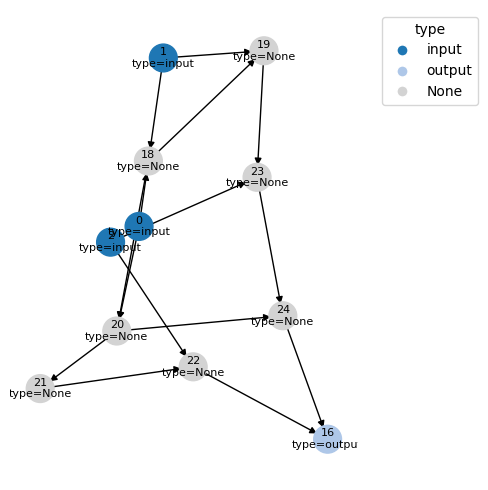

Permutation 0


{'ok': True, 'inputs': [0, 1, 2], 'outputs': [16], 'errors': [], 'warnings': []}
Permutation 1


{'ok': True, 'inputs': [0, 1, 2], 'outputs': [16], 'errors': [], 'warnings': []}


In [14]:
if plotting:
    print(f"Base circuit design")
    topology_plot_with_attrs(topology_networkx, seed = 1459)

for idx, topology_permutation in enumerate(permuted_graphs):
    print(f"Permutation {idx}")
    #small_topology_plot(topology_permutation) 
    if plotting:
        plot_circuit_layered(topology_permutation, show_in_notebook=True, notebook_width = 500, save = False) 
    
    result = validate_dag(topology_permutation, 1, raise_on_error=True, plot_on_error=True)
    print(result)


In [15]:
for nodes in topology_networkx.nodes(data = True):
    print(nodes)

(2, {'type': 'input'})
(1, {'type': 'input'})
(0, {'type': 'input'})
(16, {'type': 'output'})
(18, {})
(19, {})
(20, {})
(21, {})
(22, {})
(23, {})
(24, {})


## Import experimental data

In [16]:
input_signals_list_small_molecules, input_names, _ , _ = load_input_data("/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/input_data_3_inputs_POSTECH.json")
for row in input_signals_list_small_molecules:
    print(row)

{0: 0.0278, 1: 0.0022, 2: 0.0042}
{0: 0.0278, 1: 0.0022, 2: 2.0082}
{0: 0.0278, 1: 5.0543, 2: 0.0042}
{0: 0.0278, 1: 5.0543, 2: 2.0082}
{0: 3.9239, 1: 0.0022, 2: 0.0042}
{0: 3.9239, 1: 0.0022, 2: 2.0082}
{0: 3.9239, 1: 5.0543, 2: 0.0042}
{0: 3.9239, 1: 5.0543, 2: 2.0082}


In [17]:
input_signals_list_binary = binary_truth_table(len(input_signals_list_small_molecules[0]))
for row in input_signals_list_binary:
    print(row)

{0: 0, 1: 0, 2: 0}
{0: 0, 1: 0, 2: 1}
{0: 0, 1: 1, 2: 0}
{0: 0, 1: 1, 2: 1}
{0: 1, 1: 0, 2: 0}
{0: 1, 1: 0, 2: 1}
{0: 1, 1: 1, 2: 0}
{0: 1, 1: 1, 2: 1}


In [18]:
'''
input_signals_list_small_molecules = [
    {0: 0.0278, 1: 0.0022, 2: 0.0042},  # First set of input signals
    {0: 0.0278, 1: 0.0022, 2: 2.0082},  # Second set of input signals
    {0: 0.0278, 1: 5.0543, 2: 0.0042},  # Third set of input signals
    {0: 0.0278, 1: 5.0543, 2: 2.0082},  # First set of input signals
    {0: 3.9239, 1: 0.0022, 2: 0.0042},  # Second set of input signals
    {0: 3.9239, 1: 0.0022, 2: 2.0082},  # Third set of input signals    
    {0: 3.9239, 1: 5.0543, 2: 0.0042},  # Second set of input signals
    {0: 3.9239, 1: 5.0543, 2: 2.0082},  # Third set of input signals  
]    

input_signals_list_binary = [
    {0: 0, 1: 0, 2: 0},  # First set of input signals
    {0: 0, 1: 0, 2: 1},  # Second set of input signals
    {0: 0, 1: 1, 2: 0},  # Third set of input signals
    {0: 0, 1: 1, 2: 1},  # First set of input signals
    {0: 1, 1: 0, 2: 0},  # Second set of input signals
    {0: 1, 1: 0, 2: 1},  # Third set of input signals    
    {0: 1, 1: 1, 2: 0},  # Second set of input signals
    {0: 1, 1: 1, 2: 1},  # Third set of input signals  
]   
'''

# Load the part response experimental data
with open("/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/response_data_POSTECH.json") as f:
    repressor_data = json.load(f)

# Create DataFrame
postech_v1_hill_function_parameters = pd.DataFrame(repressor_data)

postech_v1_hill_function_parameters

protein_groups = [
    {3, 4, 5},
    {10, 11, 12},
    {14, 15},
    {16, 17, 18, 19},
]

# Load cell growth experimental data
file_path = '/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/growth_data_POSTECH.json'
with open(file_path, 'r') as file:
    data = json.load(file)

# Extract all gate toxicity data
gate_toxicity_data = [item for item in data if item.get("collection") == "gate_toxicity"]

# Convert the list of dictionaries into a DataFrame
gate_toxicity_df = pd.DataFrame(gate_toxicity_data)

# show up to 10 decimal places; adjust as you like
pd.set_option("display.float_format", "{:.10f}".format)

postech_v1_hill_function_parameters


,Repressor,RBS,ymaxa,ymina,Ka,n,Toxicity (RPU)
0,AmeR,F1,3.8350000000,1.0600000000,0.1220000000,1.3060000000,-
1,AmtR,A1,5.0360000000,0.0910000000,0.0220000000,1.3080000000,-
2,BetI,E1,3.0650000000,0.0000000000,0.3630000000,1.8330000000,-
3,BM3R1,B1,0.5430000000,0.0020000000,0.0510000000,2.0420000000,-
4,BM3R1,B2,0.8220000000,0.0000000000,0.2850000000,1.6850000000,-
5,BM3R1,B3,0.7040000000,0.0000000000,0.2610000000,1.7680000000,-
6,HlyIIR,H1,2.4620000000,0.0570000000,0.0000000000,2.5960000000,4.0652500000
7,IcaRA,I1,3.5580000000,0.0000000000,0.1860000000,1.0850000000,0.4709400000
8,LitR,L1,4.2960000000,0.0740000000,0.0000000000,1.6960000000,-
9,LmrA,N1,2.1520000000,0.1830000000,0.0000000000,2.0950000000,-


In [19]:
gate_toxicity_df

,collection,gate_name,input,growth
0,gate_toxicity,F1_AmeR,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.936601827, 0.929528441, 0.927586207, 0.9..."
1,gate_toxicity,A1_AmtR,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 1.005567327, 0.987403446, 1.01189251, 1.01..."
2,gate_toxicity,E1_BetI,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 1.465830721, 1.017868339, 1.023301985, 1.0..."
3,gate_toxicity,B1_BM3R1,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.992753623, 0.971014493, 0.992914654, 0.9..."
4,gate_toxicity,B2_BM3R1,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.978445044, 1.001274554, 1.019855551, 0.9..."
5,gate_toxicity,B3_BM3R1,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.971657754, 0.970707071, 1.015062389, 0.9..."
6,gate_toxicity,H1_HlyIIR,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.931501911, 0.945850458, 0.941163746, 0.9..."
7,gate_toxicity,I1_IcaRA,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 1.019887906, 1.026628502, 1.028642482, 1.0..."
8,gate_toxicity,L1_LitR,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 1.034190532, 1.017241379, 1.034190532, 1.0..."
9,gate_toxicity,N1_LmrA,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.948325359, 0.884901648, 0.884237108, 0.8..."


### Adquire data from objective objective function 

In [20]:
t_total_start = time.perf_counter()

#### Load possible permutations without repeating repressor

In [21]:
gate_count, info = energy_score(topology_networkx, check_implicit_OR_existence_v3)
print(f"Gate count: {gate_count}")
print(f"Info: {info}")

Gate count: 7
Info: {'num_nodes': 11, 'num_inputs': 3, 'num_outputs': 1, 'max_removal': 0, 'best_pattern_key': None}


In [22]:
DATA_DIR = Path("/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data")  
                 
file_path = DATA_DIR / "gate_permutations" / f"valid_permutations_{gate_count}_gates.h5"

list_of_gates_indices = list(range(len(postech_v1_hill_function_parameters)))
if compute_valid_permutations:
    print("Computing valid gate permutations")
    valid_permutations = generate_and_filter_permutations_v2(list_of_gates_indices, gate_count, protein_groups, max_per_group=1)
    save_valid_permutations(valid_permutations, file_path)
else:
    if file_path.is_file():           
        print(f"Found: {file_path}")
        print("Loading valid gate permutations")
        valid_permutations = load_valid_permutations(file_path)
        
    else:
        print(f"Missing: {file_path}")
        print("Computing valid gate permutations because file does not exist")   
        valid_permutations = generate_and_filter_permutations_v2(list_of_gates_indices, gate_count, protein_groups, max_per_group=1)
        save_valid_permutations(valid_permutations, file_path)   
        
print(f"Total valid permutations: {len(valid_permutations)}")
print("Example permutation:", valid_permutations[0] if valid_permutations else "No permutations found")

Found: /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/gate_permutations/valid_permutations_7_gates.h5
Loading valid gate permutations
Total valid permutations: 72999360
Example permutation: (0, 1, 2, 3, 6, 7, 8)


#### Set sample size

In [23]:
num_samples = round(len(valid_permutations)*percentage) 
subsample_size = num_samples #Use them all

#### Adquire trainning data (multiple cores)

In [24]:
Gi = permuted_graphs[permutation_index]
list(Gi.nodes(data = True))

[(2, {'type': 'input'}),
 (1, {'type': 'input'}),
 (0, {'type': 'input'}),
 (16, {'type': 'output'}),
 (18, {}),
 (19, {}),
 (20, {}),
 (21, {}),
 (22, {}),
 (23, {}),
 (24, {})]

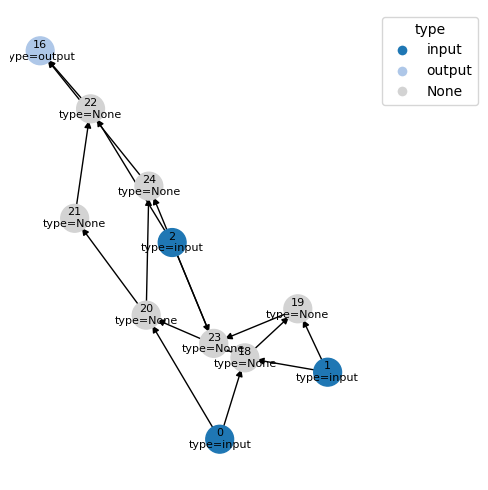

In [25]:
if plotting:
    topology_plot_with_attrs(Gi)

In [26]:
nodelist = sorted(Gi.nodes())
list(sorted(Gi.nodes(data = True)))

[(0, {'type': 'input'}),
 (1, {'type': 'input'}),
 (2, {'type': 'input'}),
 (16, {'type': 'output'}),
 (18, {}),
 (19, {}),
 (20, {}),
 (21, {}),
 (22, {}),
 (23, {}),
 (24, {})]

In [27]:
adj_matrix_sparse = nx.adjacency_matrix(Gi, nodelist=nodelist)
adj_matrix = adj_matrix_sparse.toarray()
adj_matrix

array([[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

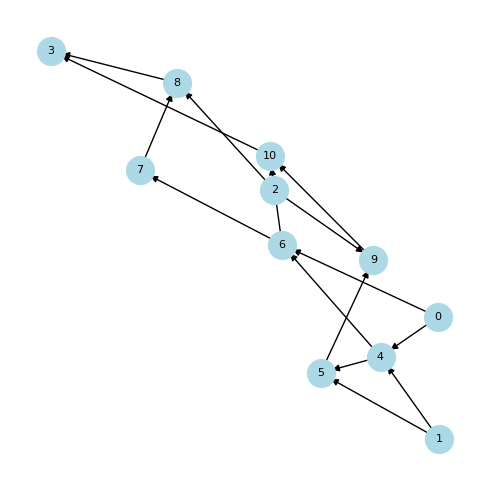

In [28]:
G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)

# Remove disconnected nodes (nodes with neither incoming nor outgoing edges)
disconnected_nodes = [node for node in G.nodes() if G.in_degree(node) == 0 and G.out_degree(node) == 0]
G.remove_nodes_from(disconnected_nodes)

if plotting:
    topology_plot_with_attrs(G)

In [29]:
input_nodes = [node for node in G.nodes() if G.in_degree(node) == 0]
output_nodes = [node for node in G.nodes() if G.out_degree(node) == 0]

# Filter nodes that are neither inputs nor outputs
non_io_nodes = [node for node in G.nodes() if node not in input_nodes and node not in output_nodes]
non_io_nodes

[4, 5, 6, 7, 8, 9, 10]

In [30]:
Gi.nodes()

NodeView((2, 1, 0, 16, 18, 19, 20, 21, 22, 23, 24))

In [31]:
Gi = permuted_graphs[permutation_index]
nodelist = sorted(Gi.nodes())
adj_matrix_sparse = nx.adjacency_matrix(Gi, nodelist=nodelist)
adj_matrix = adj_matrix_sparse.toarray()

In [32]:
nodelist

[0, 1, 2, 16, 18, 19, 20, 21, 22, 23, 24]

In [33]:
# Run parallel processing with custom file size
results_summary = parallel_process_circuits(
    adj_matrix=adj_matrix,
    valid_permutations=valid_permutations,
    experimental_params=postech_v1_hill_function_parameters,
    input_signals_small=input_signals_list_small_molecules,
    input_signals_binary=input_signals_list_binary,
    gate_toxicity_df=gate_toxicity_df,
    output_dir=Path(output_dir)/f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/training_data_{circuit_name}_design_{selected_graph}_permutation_{permutation_index}",
    num_samples=num_samples,           # Total solutions to process
    batch_size=batch_size,              # Size of each processing batch
    solutions_per_file=solutions_per_file,     # Save every solutions_per_file solutions
    num_cores = CPUs_alloc
    )

Utilizing all 80 cores for parallel processing
Solutions per file: 250,000
Expected number of files: 15
Selecting 3,649,968 random solutions from 72,999,360 valid permutations
All solutions have already been processed


Save metadata

In [ ]:
def _slug(x) -> str:
    return re.sub(r"[^A-Za-z0-9._-]+", "_", str(x))

# Build metadata strictly from existing variables
metadata = {
    "timestamp": datetime.now().isoformat(timespec="seconds"),
    "seed": global_seed,                 # from your block
    "node": hostname,                    # from your block
    "cpu": {
        "cpus_total": mp.cpu_count(),
        "cpus_allocated": CPUs_alloc,   # from your block
    },
    "gpu": {
        "num_gpus": num_gpus,           # from your block
    },
    "versions": {
        "python": platform.python_version(),
        "numpy": np.__version__,
        "torch": th.__version__,
    },
    "env": {
        "SLURM_JOB_ID": os.environ.get("SLURM_JOB_ID"),
        "SLURM_PROCID": os.environ.get("SLURM_PROCID"),
        "SLURM_NTASKS": os.environ.get("SLURM_NTASKS"),
        "SLURM_CPUS_PER_TASK": os.environ.get("SLURM_CPUS_PER_TASK"),
        "HOSTNAME": os.environ.get("HOSTNAME"),
    },
    # New: experiment/context fields from variables you set above this snippet
    "experiment": {
        "circuit_name": circuit_name,               # e.g., "0x17"
        "file_name": file_name,                     # path to designs .pkl
        "output_dir": output_dir,                   # base output dir
        # Include these if they exist in your run context
        "selected_graph": selected_graph if 'selected_graph' in globals() else None,
        "permutation_index": permutation_index if 'permutation_index' in globals() else None,
    },
}

# Save path per your spec:
# Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/run_metadata_{circuit_name}_{selected_graph}_{permutation_index}.json"
_safe_circuit = _slug(circuit_name)
_safe_graph = _slug(selected_graph) if 'selected_graph' in globals() else "NA"
_safe_perm = _slug(permutation_index) if 'permutation_index' in globals() else "NA"

_base = Path(output_dir) / f"{_safe_circuit}_design_{_safe_graph}_permutation_{_safe_perm}"
_base.mkdir(parents=True, exist_ok=True)

_save_path = _base / f"run_metadata_{_safe_circuit}_{_safe_graph}_{_safe_perm}.json"
with open(_save_path, "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2, sort_keys=True)

print(f"[metadata] wrote to {_save_path}")

In [34]:
load_saved_seed = True


if load_saved_seed:   

    _base = Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}"
    metadata_path = _base / f"run_metadata_{circuit_name}_{selected_graph}_{permutation_index}.json"

    if load_saved_seed:
        with open(metadata_path, "r", encoding="utf-8") as f:
            global_seed = int(json.load(f)["seed"])

        # Set seed (exactly as original)
        print(f"Loaded random seed {global_seed}")
        random.seed(global_seed)
        np.random.seed(global_seed)
        th.manual_seed(global_seed)

Loaded random seed 3134205841


In [35]:
run_timing_analysis = False

Timing plot with total times

In [ ]:
if run_timing_analysis:


    core_grid = [10, 20, 40, 80, 100, 120]  

    # Fix the workload so runs are comparable
    rng = random.Random(123)
    random_indices = rng.sample(range(len(valid_permutations)), num_samples)
    fixed_perms = [valid_permutations[i] for i in random_indices]

    times = []
    for n in core_grid:
        print(f"\n=== Testing num_cores={n} ===")
        t0 = time.perf_counter()
        
        # Use a unique subdir so runs don't interfere
        outdir_n = Path(output_dir)/f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/mp_time_data_v1/{circuit_name}_design_{selected_graph}_permutation_{permutation_index}_{n}_workers"

        results_summary = parallel_process_circuits(
            adj_matrix=adj_matrix,
            valid_permutations=fixed_perms,                   # <- fixed workload
            experimental_params=postech_v1_hill_function_parameters,
            input_signals_small=input_signals_list_small_molecules,
            input_signals_binary=input_signals_list_binary,
            gate_toxicity_df=gate_toxicity_df,
            output_dir=outdir_n,                              # <- unique output
            num_samples=num_samples,
            batch_size=batch_size,
            solutions_per_file=solutions_per_file,
            num_cores=n
        )
        times.append(time.perf_counter() - t0)

    # Plot
    plt.figure()
    plt.plot(core_grid, times, "-o")
    plt.xlabel("num_cores (processes)")
    plt.ylabel("Runtime (s)")
    plt.title("Runtime vs num_cores")
    plt.grid(True)
    plt.show()

Timing plot with time versus solutions

In [ ]:
if run_timing_analysis:


    core_grid = [20, 40, 80]  # ≤ CPUs_alloc

    # Fix workload for fair comparison
    rng = random.Random(123)
    random_indices = rng.sample(range(len(valid_permutations)), num_samples)
    fixed_perms = [valid_permutations[i] for i in random_indices]

    run_summaries = []

    for n in core_grid:
        print(f"\n=== Testing num_cores={n} ===")
        outdir_n = Path(output_dir)/f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/mp_time_data_v2/{circuit_name}_design_{selected_graph}_permutation_{permutation_index}_{n}_workers"

        summary = parallel_process_circuits(
            adj_matrix=adj_matrix,
            valid_permutations=fixed_perms,                   # fixed workload
            experimental_params=postech_v1_hill_function_parameters,
            input_signals_small=input_signals_list_small_molecules,
            input_signals_binary=input_signals_list_binary,
            gate_toxicity_df=gate_toxicity_df,
            output_dir=outdir_n,                              # unique output
            num_samples=num_samples,
            batch_size=batch_size,
            solutions_per_file=solutions_per_file,
            num_cores=n
        )
        run_summaries.append((n, summary))

        # Plot: x = time, y = number of solutions 
        plt.rcParams.update({
            "font.size": 6, "axes.titlesize": 6, "axes.labelsize": 6,
            "legend.fontsize": 6, "xtick.labelsize": 6, "ytick.labelsize": 6,
        })
        edge_col, edge_w = "#58595B", 0.5
        palette = ["#417FF1", "#E06C4B", "#23A36E", "#7A61D1"]
        pt_to_in = lambda pt: pt / 72.0

        fig, ax = plt.subplots(1, 1, figsize=(pt_to_in(150), pt_to_in(100)), dpi=250)

        for i, (n, summary) in enumerate(run_summaries):
            prog = summary['progress']  # list of (elapsed_s, processed_solutions)
            xs = [t/60.0 for (t, _) in prog]   # minutes on x-axis
            ys = [s for (_, s) in prog]
            col = palette[i % len(palette)]

            ax.plot(xs, ys, linestyle="-", linewidth=0.5, marker="o", markersize=2,
                    color=col, markerfacecolor="none", markeredgewidth=0.7,
                    markeredgecolor=col, label=f"{n} cores", rasterized=False)
            ax.scatter(xs[-1], ys[-1], s=9, facecolors="none", edgecolors=col, linewidths=0.9)

        ax.set_xlabel("Time (minutes)", labelpad=4)
        ax.set_ylabel("Number of solutions processed", labelpad=4)
        ax.set_title("Solutions vs Time for different num_cores")

        # spines & ticks
        for spine in ax.spines.values():
            spine.set_color(edge_col); spine.set_linewidth(edge_w)
        ax.tick_params(axis="both", which="major", direction="out", length=4, width=edge_w,
                    colors=edge_col, pad=1)
        ax.xaxis.label.set_color(edge_col); ax.yaxis.label.set_color(edge_col)
        ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=8))
        ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=6))

        # --- scientific notation on Y ---
        ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0), useMathText=True)
        # match the offset “×10^n” text to your style
        off = ax.yaxis.get_offset_text()
        off.set_size(6); off.set_color(edge_col)

        ax.legend(
        title="Workers",
        loc="center left",           # place the legend's left side…
        bbox_to_anchor=(1.02, 0.5),  # …just outside the right edge of the axes
        frameon=False,
        markerscale=1.5
        )
        
        plt.tight_layout()

In [ ]:
if run_timing_analysis:
    fig.savefig(Path(output_dir)  / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/CPU_workers_vs_solutions_plot_{circuit_name}_{selected_graph}_{permutation_index}.pdf",  # or .png / .svg, etc.
                dpi=250,                         
                bbox_inches="tight")  

### Load training data

In [36]:
# Load all results
(permutations, toxicity_scores, circuit_scores, roadblocking_flags) = load_circuit_results(Path(output_dir)/f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/training_data_{circuit_name}_design_{selected_graph}_permutation_{permutation_index}")

if len(permutations) > 0:
    # Print data shape summary
    print("\nData shape summary:")
    print(f"Permutations shape: {permutations.shape}")
    print(f"Toxicity scores shape: {toxicity_scores.shape}")
    print(f"Circuit scores shape: {circuit_scores.shape}")
    print(f"Roadblocking flags shape: {roadblocking_flags.shape}")

Found 15 batch files to load


Loading results:  13%|█████████████████▎                                                                                                                | 2/15 [00:12<01:20,  6.17s/it]


Processed 500,000 solutions so far...


Loading results:  27%|██████████████████████████████████▋                                                                                               | 4/15 [00:24<01:08,  6.22s/it]


Processed 1,000,000 solutions so far...


Loading results:  40%|████████████████████████████████████████████████████                                                                              | 6/15 [00:37<00:57,  6.36s/it]


Processed 1,500,000 solutions so far...


Loading results:  53%|█████████████████████████████████████████████████████████████████████▎                                                            | 8/15 [00:50<00:45,  6.47s/it]


Processed 2,000,000 solutions so far...


Loading results:  67%|██████████████████████████████████████████████████████████████████████████████████████                                           | 10/15 [01:04<00:32,  6.57s/it]


Processed 2,500,000 solutions so far...


Loading results:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 12/15 [01:19<00:21,  7.10s/it]


Processed 3,000,000 solutions so far...


Loading results:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 14/15 [01:33<00:07,  7.02s/it]


Processed 3,500,000 solutions so far...


Loading results: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:36<00:00,  6.43s/it]



Loading completed:
Total results loaded: 3,649,968
Unique permutations: 3,649,968
Average circuit score: 0.523
Average toxicity score: 0.486
Roadblocking percentage: 90.9%

Data shape summary:
Permutations shape: (3649968, 7)
Toxicity scores shape: (3649968,)
Circuit scores shape: (3649968,)
Roadblocking flags shape: (3649968,)


### List top biological designs in the training data

In [37]:
no_roadblock_mask_training_data = ~roadblocking_flags
permutations_no_roadblocking_training_data = permutations[no_roadblock_mask_training_data]
circuit_scores_no_roadblocking_training_data = circuit_scores[no_roadblock_mask_training_data]
toxicity_scores_no_roadblocking_training_data = toxicity_scores[no_roadblock_mask_training_data]
roadblocking_flags_no_roadblocking_training_data = roadblocking_flags[no_roadblock_mask_training_data]

toxicity_filter_training_data = toxicity_scores_no_roadblocking_training_data >= growth_score_threshold
permutations_no_roadblocking_toxicity_filtered_training_data = permutations_no_roadblocking_training_data[toxicity_filter_training_data]
circuit_scores_no_roadblocking_toxicity_filtered_training_data = circuit_scores_no_roadblocking_training_data[toxicity_filter_training_data]
toxicity_scores_no_roadblocking_toxicity_filtered_training_data = toxicity_scores_no_roadblocking_training_data[toxicity_filter_training_data]
roadblocking_flags_no_roadblocking_toxicity_filtered_training_data = roadblocking_flags_no_roadblocking_training_data[toxicity_filter_training_data]

#print(circuit_scores_no_roadblocking_toxicity_filtered_training_data)

In [38]:
print(len(circuit_scores_no_roadblocking_toxicity_filtered_training_data))

4388


In [39]:
# Find top N circuit scores
N_training_data = 3  # Change this number to get more or fewer top scores
top_n_indices_training_data = np.argsort(circuit_scores_no_roadblocking_toxicity_filtered_training_data)[-N_training_data:][::-1]  # Get indices of top N scores in descending order

print(f"\nTop {N_training_data} Circuit Scores (no roadblocking, toxicity >= {growth_score_threshold}):")
print("Rank | Circuit Score | Toxicity Score | Roadblocking | Permutation")
print("-" * 100)

# Store highest score details for later
highest_score_details_training_data = {}

for rank, idx in enumerate(top_n_indices_training_data, 1):
    
    corresponding_index_training_data = idx

    best_permutation_training_data = permutations_no_roadblocking_toxicity_filtered_training_data[corresponding_index_training_data]

    roadblock_flag_training_data = roadblocking_flags_no_roadblocking_toxicity_filtered_training_data[corresponding_index_training_data]

    print(f"{rank:4d} | {circuit_scores_no_roadblocking_toxicity_filtered_training_data[idx]:12.4f} | "
          f"{toxicity_scores_no_roadblocking_toxicity_filtered_training_data[idx]:13.4f} | "
          f"{str(roadblock_flag_training_data):11} | {best_permutation_training_data}")

    # Store details for rank 1
    if rank == 1:
        highest_score_details_training_data = {
            'circuit_score': circuit_scores_no_roadblocking_toxicity_filtered_training_data[idx],
            'toxicity_score': toxicity_scores_no_roadblocking_toxicity_filtered_training_data[idx],
            'roadblocking': roadblock_flag_training_data,
            'permutation': best_permutation_training_data
        }

# Print detailed information for highest scoring design after the table
print("\n" + "-"*100)
print("Detailed information for highest scoring design:")
print("-"*100)
print(f"Highest actual circuit score: {highest_score_details_training_data['circuit_score']}")
print(f"Corresponding actual toxicity score: {highest_score_details_training_data['toxicity_score']}")
print(f"Roadblocking: {highest_score_details_training_data['roadblocking']}")
print(f"Permutation: {highest_score_details_training_data['permutation']}")


Top 3 Circuit Scores (no roadblocking, toxicity >= 0.65):
Rank | Circuit Score | Toxicity Score | Roadblocking | Permutation
----------------------------------------------------------------------------------------------------
   1 |       3.4805 |        0.6628 | False       | [ 2  0 19  1 11 13  4]
   2 |       3.4496 |        0.6705 | False       | [ 1  0 11 13 15  2 19]
   3 |       3.4248 |        0.6556 | False       | [13  2 19  1  5  0 12]

----------------------------------------------------------------------------------------------------
Detailed information for highest scoring design:
----------------------------------------------------------------------------------------------------
Highest actual circuit score: 3.4804805721319867
Corresponding actual toxicity score: 0.6627698994120387
Roadblocking: False
Permutation: [ 2  0 19  1 11 13  4]


In [40]:
rows = []
for rank, idx in enumerate(top_n_indices_training_data, 1):
    rows.append({
        "Rank"            : rank,
        "Circuit Score"   : circuit_scores_no_roadblocking_toxicity_filtered_training_data[idx],
        "Toxicity Score"  : toxicity_scores_no_roadblocking_toxicity_filtered_training_data[idx],
        "Roadblocking"    : roadblocking_flags_no_roadblocking_toxicity_filtered_training_data[idx],
        "Permutation"     : permutations_no_roadblocking_toxicity_filtered_training_data[idx],
    })


csv_path = Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/scores_top_designs_in_trainning_data_{circuit_name}_{selected_graph}_{permutation_index}.csv"
with open(csv_path, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=rows[0].keys())
    writer.writeheader()
    writer.writerows(rows)

print(f"\n Saved {len(rows)} rows to {csv_path}")


 Saved 3 rows to /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/stratch/0x6D_design_0_permutation_0/scores_top_designs_in_trainning_data_0x6D_0_0.csv


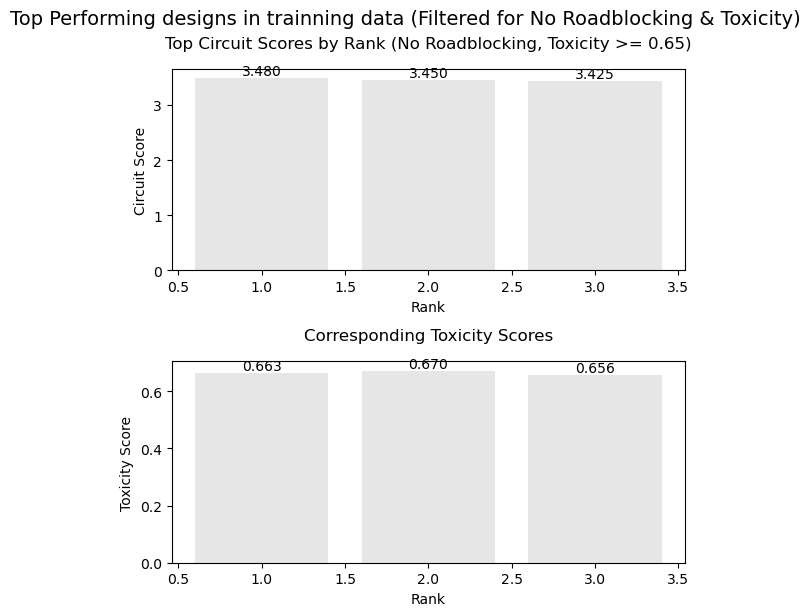


Statistics Summary:
--------------------------------------------------
Circuit Scores - Mean: 3.452, Std: 0.023
Toxicity Scores - Mean: 0.663, Std: 0.006


In [41]:
if plotting:
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))
    fig.tight_layout(pad=4.0)  # Add space between subplots

    # Data preparation
    ranks = list(range(1, N_training_data + 1))
    circuit_scores_training_data_top = circuit_scores_no_roadblocking_toxicity_filtered_training_data[top_n_indices_training_data]
    toxicity_scores_training_data_top = toxicity_scores_no_roadblocking_toxicity_filtered_training_data[top_n_indices_training_data]

    # Plot 1: Circuit Scores
    bars1 = ax1.bar(ranks, circuit_scores_training_data_top, color='gainsboro', alpha=0.7)
    ax1.set_title(f'Top Circuit Scores by Rank (No Roadblocking, Toxicity >= {growth_score_threshold})', fontsize=12, pad=15)
    ax1.set_xlabel('Rank')
    ax1.set_ylabel('Circuit Score')
    #ax1.grid(True, linestyle='--', alpha=0.7)

    # Add value labels on top of bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', rotation=0)

    # Plot 2: Toxicity Scores
    bars2 = ax2.bar(ranks, toxicity_scores_training_data_top, color='gainsboro', alpha=0.7)
    ax2.set_title('Corresponding Toxicity Scores', fontsize=12, pad=15)
    ax2.set_xlabel('Rank')
    ax2.set_ylabel('Toxicity Score')
    #ax2.grid(False, linestyle='--', alpha=0.7)

    # Add value labels on top of bars
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', rotation=0)

    # Adjust layout
    plt.tight_layout()

    # Add a title for the entire figure
    fig.suptitle('Top Performing designs in trainning data (Filtered for No Roadblocking & Toxicity)', fontsize=14, y=1.02)

    # Save figure if needed
    # plt.savefig('top_circuits_analysis_filtered.png', dpi=300, bbox_inches='tight')

    plt.show()

    # Print some statistics
    print("\nStatistics Summary:")
    print("-" * 50)
    print(f"Circuit Scores - Mean: {np.mean(circuit_scores_training_data_top):.3f}, Std: {np.std(circuit_scores_training_data_top):.3f}")
    print(f"Toxicity Scores - Mean: {np.mean(toxicity_scores_training_data_top):.3f}, Std: {np.std(toxicity_scores_training_data_top):.3f}")

In [42]:
G_train_data = assign_representations_with_io_nodes_3(adj_matrix, postech_v1_hill_function_parameters, highest_score_details_training_data['permutation'])


# Calculate toxicity
toxicity_score_train_data, _ = calculate_toxicity_score(
    input_signals_list_small_molecules,
    G_train_data,
    gate_toxicity_df
)

# Simulate logic
actual_logic_train_data = simulate_signal_propagation(
    G_train_data,
    input_signals_list_small_molecules
)
expected_logic_train_data = simulate_signal_propagation_binary(
    G_train_data,
    input_signals_list_binary
)

# Calculate scores
current_score_train_data = calculate_circuit_score(expected_logic_train_data, actual_logic_train_data)
roadblocking_flag_train_data = is_roadblocking(G_train_data)

print(f'Current score: {current_score_train_data}')
print(f'Toxicity score:{toxicity_score_train_data}')
print(f'Roadblocking: {roadblocking_flag_train_data}')

Current score: 3.4804805721319867
Toxicity score:0.6627698994120387
Roadblocking: (False, [])


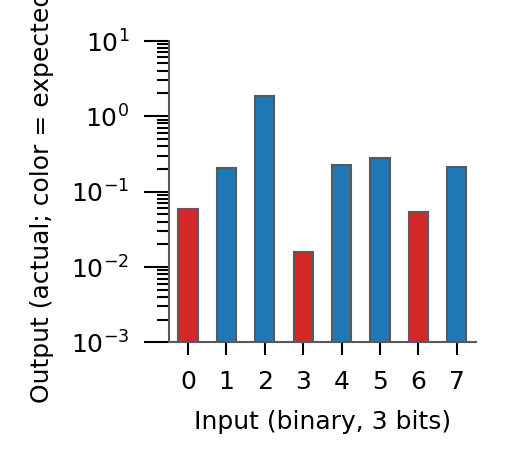

In [43]:
if plotting:

    # --- Text & style settings you requested ---
    plt.rcParams.update({
        "font.size": 6, "axes.titlesize": 6, "axes.labelsize": 6,
        "legend.fontsize": 6, "xtick.labelsize": 6, "ytick.labelsize": 6,
    })
    edge_col, edge_w = "#58595B", 0.5
    pt_to_in = lambda pt: pt / 72  # helper if you want to size in points

    # --- Data prep (list of dicts for outputs) ---
    # actual_logic_train_data = [{3: ...}, ...]  # 8 items for a 3-input circuit
    # expected_logic_train_data = [{3: ...}, ...]  # same length/order as actual
    values_actual = [next(iter(d.values())) for d in actual_logic_train_data]
    values_expected = [next(iter(d.values())) for d in expected_logic_train_data]

    n = len(values_actual)
    n_inputs = max(1, math.ceil(math.log2(n)))
    labels = [format(i, f'0{n_inputs}b') for i in range(n)]
    x = np.arange(n)

    # Colors are determined by expected outputs (blue = expected high, red = expected low)
    threshold = 0.5  # adjust if your expected values are 0/1; e.g., use 0.5
    colors = ["tab:blue" if v_exp >= threshold else "tab:red" for v_exp in values_expected]

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(pt_to_in(120), pt_to_in(110)), dpi=300)

    ax.bar(x, values_actual, width=0.5, color=colors, edgecolor=edge_col, linewidth=edge_w)

    ax.set_yscale("log")
    ax.set_ylim(1e-3, 1e1)
    ax.set_xlim(-0.5, n - 0.5)

    ax.set_xticks(x)
    # ax.set_xticklabels(labels)

    # Make major y-ticks (with labels) longer; keep minor shorter
    ax.tick_params(axis="y", which="major", width=edge_w, length=6)
    ax.tick_params(axis="y", which="minor", width=edge_w, length=3)
    ax.tick_params(axis="x", which="both", width=edge_w, length=3)

    # Spine styling
    for s in ["left", "bottom"]:
        ax.spines[s].set_linewidth(edge_w)
        ax.spines[s].set_color(edge_col)
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)

    ax.set_xlabel(f"Input (binary, {n_inputs} bits)")
    ax.set_ylabel("Output (actual; color = expected)")

    fig.tight_layout()
    plt.show()

In [44]:
actual_logic_train_data

[{3: 0.059172864466801034},
 {3: 0.20595000517410017},
 {3: 1.8689152784620366},
 {3: 0.01587944286835536},
 {3: 0.22694780561891822},
 {3: 0.2791162184163786},
 {3: 0.053287979830888316},
 {3: 0.21077526944060465}]

In [45]:
if plotting:
    fig.savefig(Path(output_dir) /f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/optimal_design_in_train_data_simulation_{circuit_name}_{selected_graph}_{permutation_index}.pdf", dpi=300, bbox_inches="tight")

### Prepare data for training 

In [46]:
X_all = np.array(permutations).astype(np.float32)  # Convert all_permutations to a NumPy array
y_all = np.column_stack((toxicity_scores, circuit_scores)).astype(np.float32)  # Convert to a NumPy array
roadblocking_flags = np.array(roadblocking_flags)  # Convert all_roadblocking_flags to a NumPy array

num_classes = len(postech_v1_hill_function_parameters)
num_biological_parts = gate_count

In [47]:
# Data Preparation and Filter by circuit score > 0and roadblocking
#filter_mask = (y_all[:, 1] > 0) & (roadblocking_flags == False)

# Data Preparation and Filter by circuit score > n
filter_mask = y_all[:, 1] >= 0

X_all_filtered = X_all[filter_mask]
y_all_circuit_scores_filtered = y_all[filter_mask, 1]
y_all_toxicity_scores_filtered = y_all[filter_mask, 0]

print("Data " ,len(X_all_filtered))

#Subsample randomly and maintain order of data

# Check if we have enough samples and generate indices for subsampling
if len(X_all_filtered) >= subsample_size:
    # Get random indices and sort them to maintain order
    subsample_indices = np.sort(np.random.choice(len(X_all_filtered), subsample_size, replace=False))
else:
    print(f"Warning: Requested {subsample_size} samples, but only {len(X_all_filtered)} are available after filtering.")
    subsample_indices = np.arange(len(X_all_filtered))  # Simply use all indices in order
    subsample_size = len(X_all_filtered)  # Adjust subsample_size to the available data
    
# Subsample the data
X_all_filtered_subsampled = X_all_filtered[subsample_indices]
y_all_circuit_scores_filtered_subsampled = y_all_circuit_scores_filtered[subsample_indices]
y_all_toxicity_scores_filtered_subsampled = y_all_toxicity_scores_filtered[subsample_indices]

# Convert X to PyTorch tensor and perform one-hot encoding
X_all_filtered_subsampled_tensor = th.from_numpy(X_all_filtered_subsampled).long()
X_all_filtered_subsampled_tensor_one_hot = F.one_hot(X_all_filtered_subsampled_tensor, num_classes=num_classes).float()

# Convert y to PyTorch tensors
y_all_circuit_scores_filtered_subsampled_tensor = th.from_numpy(y_all_circuit_scores_filtered_subsampled).float().unsqueeze(1)
y_all_toxicity_scores_filtered_subsampled_tensor = th.from_numpy(y_all_toxicity_scores_filtered_subsampled).float().unsqueeze(1)

# Split the data into train / val / test
train_ratio = 0.80
val_ratio   = 0.10  # test will be the remainder 

num_samples = X_all_filtered_subsampled_tensor_one_hot.shape[0]
num_train = int(train_ratio * num_samples)
num_val   = int(val_ratio * num_samples)
num_test  = num_samples - num_train - num_val  # ensure all samples are used

perm = np.random.permutation(num_samples)
train_idx = perm[:num_train]
val_idx   = perm[num_train:num_train + num_val]
test_idx  = perm[num_train + num_val:]

# Build splits
X_training_set = X_all_filtered_subsampled_tensor_one_hot[train_idx]
y_circuit_scores_training_set = y_all_circuit_scores_filtered_subsampled_tensor[train_idx]
y_toxicity_scores_training_set = y_all_toxicity_scores_filtered_subsampled_tensor[train_idx]

X_val_set = X_all_filtered_subsampled_tensor_one_hot[val_idx]
y_circuit_scores_val_set = y_all_circuit_scores_filtered_subsampled_tensor[val_idx]
y_toxicity_scores_val_set = y_all_toxicity_scores_filtered_subsampled_tensor[val_idx]

X_test_set = X_all_filtered_subsampled_tensor_one_hot[test_idx]
y_circuit_scores_test_set = y_all_circuit_scores_filtered_subsampled_tensor[test_idx]
y_toxicity_scores_test_set = y_all_toxicity_scores_filtered_subsampled_tensor[test_idx]

print(f"Split sizes -> train: {len(train_idx)}, val: {len(val_idx)}, test: {len(test_idx)}")

# Device Setup
device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Shuffle training data
shuffle_indices = th.randperm(X_training_set.size(0))
X_training_set_shuffled = X_training_set[shuffle_indices].to(device)
y_circuit_scores_training_set_shuffled = y_circuit_scores_training_set[shuffle_indices].to(device)
y_toxicity_scores_training_set_shuffled = y_toxicity_scores_training_set[shuffle_indices].to(device)

# Move val/test to device
X_val_set = X_val_set.to(device)
y_circuit_scores_val_set = y_circuit_scores_val_set.to(device)
y_toxicity_scores_val_set = y_toxicity_scores_val_set.to(device)

X_test_set = X_test_set.to(device)
y_circuit_scores_test_set = y_circuit_scores_test_set.to(device)
y_toxicity_scores_test_set = y_toxicity_scores_test_set.to(device)

Data  3649968
Split sizes -> train: 2919974, val: 364996, test: 364998
Using device: cuda


### Model size

In [48]:
input_size = num_biological_parts * num_classes

train_batch_size = 4096
if gate_count < 5:
    train_batch_size = round(4096/100)    

hidden_size = 100
output_size = 1

circuit_score_layers = 9
toxicity_score_layers = 9

### Trainning

In [ ]:
mp.set_start_method("spawn", force=True)

num_epochs_circuit_score_model = 25
num_epochs_toxicity_score_model = 25

n_available = th.cuda.device_count()
gpu_ids = list(range(n_available))

jobs = [
    TrainJob(
        name="circuit_score",
        gpu_id=gpu_ids[0] if len(gpu_ids) >= 1 else None,
        seed=global_seed,
        input_size=input_size, hidden_size=hidden_size, output_size=1,
        num_layers=circuit_score_layers, dropout=0.0, lr=1e-3,
        X_train=X_training_set_shuffled,
        y_train=y_circuit_scores_training_set_shuffled,
        X_val=X_val_set,
        y_val=y_circuit_scores_val_set,
        num_epochs=num_epochs_circuit_score_model,
        batch_size=train_batch_size,
        evaluate_validation_set = True,
        early_stop_patience=10,
        early_stop_min_delta=1e-3,
        out_path=Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/circuit_score_model.pt"
    ),
    TrainJob(
        name="toxicity_score",
        gpu_id=gpu_ids[1] if len(gpu_ids) >= 2 else (gpu_ids[0] if len(gpu_ids) == 1 else None),
        seed=global_seed + 1,
        input_size=input_size, hidden_size=hidden_size, output_size=1,
        num_layers=toxicity_score_layers, dropout=0.0, lr=1e-3,
        X_train=X_training_set_shuffled,
        y_train=y_toxicity_scores_training_set_shuffled,
        X_val=X_val_set,
        y_val=y_toxicity_scores_val_set,
        num_epochs=num_epochs_toxicity_score_model,
        batch_size=train_batch_size,
        evaluate_validation_set = True,
        early_stop_patience=10,
        early_stop_min_delta=1e-5,
        out_path=Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/toxicity_score_model.pt"
    ),
]

manager = mp.Manager()
results = manager.dict()
procs = []

if n_available >= 2:
    for job in jobs:
        p = mp.Process(target=run_one_job, args=(job, results))
        p.start()
        procs.append(p)
    for p in procs:
        p.join()
else:
    for job in jobs:
        run_one_job(job, results)

print("Training finished:")
for name, info in dict(results).items():
    fm = info.get("final_metric", float("nan"))
    print(f" - {name}: device={info['device']} final={fm:.6f} saved={info['model_path']}")


In [49]:
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")

# instantiate empty models with the SAME architecture as training 
model_circuit_score = RegressionNN(input_size, hidden_size, output_size, num_layers=circuit_score_layers, dropout=0.0, activation=nn.ReLU)
model_toxicity_score = RegressionNN(input_size, hidden_size, output_size, num_layers=toxicity_score_layers, dropout=0.0, activation=nn.ReLU)

# load weights using your load_model() 
load_model(model_circuit_score, Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/circuit_score_model.pt")
load_model(model_toxicity_score, Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/toxicity_score_model.pt")

# move to device + eval mode 
model_circuit_score = model_circuit_score.to(device).eval()
model_toxicity_score = model_toxicity_score.to(device).eval()

print(f"circuit_score on {next(model_circuit_score.parameters()).device}")
print(f"toxicity_score on {next(model_toxicity_score.parameters()).device}")

circuit_score on cuda:0
toxicity_score on cuda:0


In [50]:
circ_losses_path = Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/circuit_score_model_losses.pt"
tox_losses_path  = Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/toxicity_score_model_losses.pt"

circ_train, circ_val, circ_meta = load_losses(circ_losses_path)
tox_train,  tox_val,  tox_meta  = load_losses(tox_losses_path)

model_circuit_score_losses = (circ_train, circ_val)
model_toxicity_score_losses = (tox_train,  tox_val)

Plot losses

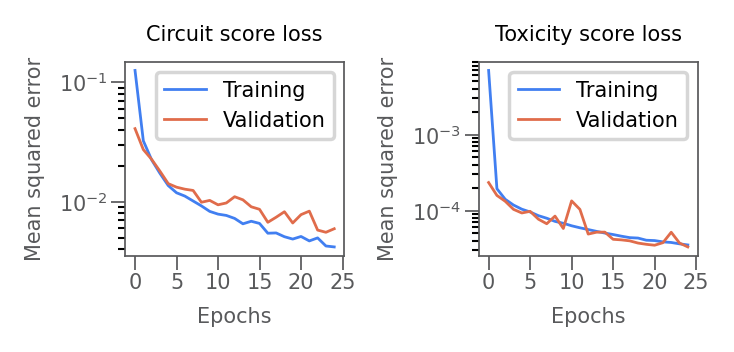

In [51]:
if plotting:
    # Figure-wide typography and sizing (unchanged)
    plt.rcParams.update({
        "font.size": 6,
        "axes.titlesize": 6,
        "axes.labelsize": 6,
        "legend.fontsize": 6,
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
        "pdf.fonttype": 42,           # embed TrueType so text stays editable in Illustrator
        "ps.fonttype": 42,            # same for EPS (if you ever export EPS)
        "pdf.use14corefonts": False,  # allow embedding non-core fonts
        "svg.fonttype": "none",      
    })

    # Canvas set-up (unchanged)
    pt_to_in = lambda pt: pt / 72.0
    edge_col, edge_w = "#58595B", 0.5

    fig, (ax_circ, ax_tox) = plt.subplots(
        1, 2,
        figsize=(pt_to_in(210), pt_to_in(100)),
        dpi=250,
        sharex=False, sharey=False
    )
    fig.subplots_adjust(wspace=0.30)

    # --- Helper for safe plotting with optional validation ---
    def _has_data(arr):
        try:
            return (arr is not None) and (np.size(arr) > 0)
        except Exception:
            return False

    def _plot_losses(ax, train_losses, val_losses, num_epochs, title):
        # Training curve
        if _has_data(train_losses):
            n_train = min(num_epochs, len(train_losses))
            ax.plot(np.arange(n_train), train_losses[:n_train],
                    label="Training", linewidth=0.8, color="#417FF1")

        # Validation curve (only if provided)
        if _has_data(val_losses):
            n_val = min(num_epochs, len(val_losses))
            ax.plot(np.arange(n_val), val_losses[:n_val],
                    label="Validation", linewidth=0.8, color="#E06C4B")

        ax.set_xlabel("Epochs", labelpad=4)
        ax.set_ylabel("Mean squared error", labelpad=4)
        ax.set_title(title)

        # Only show legend if at least one line exists
        handles, labels = ax.get_legend_handles_labels()
        if handles:
            ax.legend(loc="upper right")

    # Loss curves (now robust to missing/None validation losses)
    _plot_losses(
        ax_circ,
        model_circuit_score_losses[0],
        (model_circuit_score_losses[1]
        if isinstance(model_circuit_score_losses, (list, tuple, np.ndarray)) and len(model_circuit_score_losses) > 1
        else None),
        num_epochs_circuit_score_model,
        "Circuit score loss"
    )

    _plot_losses(
        ax_tox,
        model_toxicity_score_losses[0],
        (model_toxicity_score_losses[1]
        if isinstance(model_toxicity_score_losses, (list, tuple, np.ndarray)) and len(model_toxicity_score_losses) > 1
        else None),
        num_epochs_toxicity_score_model,
        "Toxicity score loss"
    )

    # Shared axis cosmetics
    for ax in (ax_circ, ax_tox):
        # frame colour / width
        for spine in ax.spines.values():
            spine.set_color(edge_col)
            spine.set_linewidth(edge_w)

        # tick appearance
        ax.tick_params(direction="out", length=4, width=edge_w,
                    colors=edge_col, pad=1)

        # tidy y-ticks
        ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=8))

        # label colour
        ax.xaxis.label.set_color(edge_col)
        ax.yaxis.label.set_color(edge_col)

        # optional grid
        # ax.grid(False, linestyle="--", linewidth=0.3, alpha=0.7)
        
        ax.set_yscale('log')

    # Different major-tick spacing for each panel
    ax_circ.xaxis.set_major_locator(mticker.MultipleLocator(5))  # left panel
    ax_tox.xaxis.set_major_locator(mticker.MultipleLocator(5))   # right panel

    plt.tight_layout()
    plt.show()


In [52]:
if plotting:
    fig.savefig(Path(output_dir)  / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/loss_curves_{circuit_name}_{selected_graph}_{permutation_index}.pdf",  # or .png / .svg, etc.
                dpi=250,                         # keep same resolution as on-screen
                bbox_inches="tight")  

### Characterization on test set

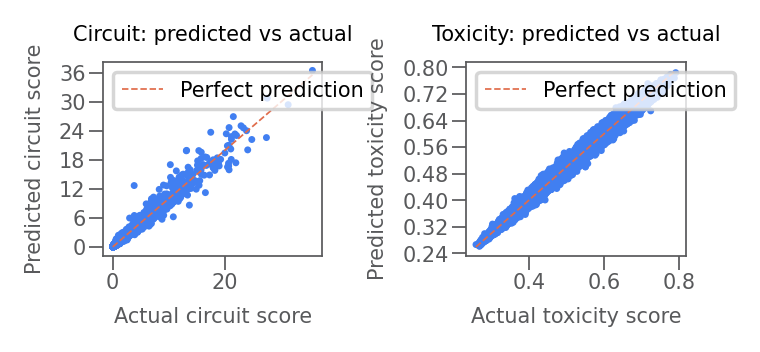


Test-set circuit score:
  MSE  = 0.0063
  RMSE = 0.0791
  R²   = 0.9824
  ρ    = 0.9913

Test-set toxicity score:
  MSE  = 0.0000
  RMSE = 0.0058
  R²   = 0.9955
  ρ    = 0.9979
Saved metrics to /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/stratch/0x6D_design_0_permutation_0/model_performance_on_testing_set.csv


In [53]:
# Get model predictions on test set
model_circuit_score.eval()
model_toxicity_score.eval()

# Move test data and models to available device
model_circuit_score = model_circuit_score.to(device)
model_toxicity_score = model_toxicity_score.to(device)
X_test_set = X_test_set.to(device)

# Make predictions
with th.no_grad():
    test_pred_circuit = model_circuit_score(X_test_set)
    test_pred_toxicity = model_toxicity_score(X_test_set)

# Convert everything to numpy arrays for plotting
test_pred_circuit = test_pred_circuit.cpu().numpy().flatten()
test_pred_toxicity = test_pred_toxicity.cpu().numpy().flatten()
test_actual_circuit = y_circuit_scores_test_set.cpu().numpy().flatten()
test_actual_toxicity = y_toxicity_scores_test_set.cpu().numpy().flatten()

if plotting:
    plt.rcParams.update({
        "font.size": 6, "axes.titlesize": 6, "axes.labelsize": 6,
        "legend.fontsize": 6, "xtick.labelsize": 6, "ytick.labelsize": 6,
        "pdf.fonttype": 42,           # embed TrueType so text stays editable in Illustrator
        "ps.fonttype": 42,            # same for EPS (if you ever export EPS)
        "pdf.use14corefonts": False,  # allow embedding non-core fonts
        "svg.fonttype": "none",  
    })

    edge_col, edge_w = "#58595B", 0.5
    pt_to_in = lambda pt: pt / 72           

    fig, (ax_circ, ax_tox) = plt.subplots(
        1, 2,
        figsize=(pt_to_in(210), pt_to_in(100)),  
        dpi=250,
        sharex=False, sharey=False
    )
    fig.subplots_adjust(wspace=0.30)

    ax_circ.scatter(test_actual_circuit, test_pred_circuit,
                    s=4,  c="#417FF1", alpha=1, edgecolors="none", rasterized=False)
    ax_circ.plot([test_actual_circuit.min(), test_actual_circuit.max()],
                [test_actual_circuit.min(), test_actual_circuit.max()],
                linestyle="--", linewidth=0.5, color="#E06C4B", label="Perfect prediction")
    ax_circ.set_xlabel("Actual circuit score",  labelpad=4)
    ax_circ.set_ylabel("Predicted circuit score", labelpad=4)
    ax_circ.set_title("Circuit: predicted vs actual")
    ax_circ.legend(loc="upper left", markerscale=5)

    ax_tox.scatter(test_actual_toxicity, test_pred_toxicity,
                s=4,  c="#417FF1", alpha=1, edgecolors="none", rasterized=False)
    ax_tox.plot([test_actual_toxicity.min(), test_actual_toxicity.max()],
                [test_actual_toxicity.min(), test_actual_toxicity.max()],
                linestyle="--", linewidth=0.5, color="#E06C4B", label="Perfect prediction")
    ax_tox.set_xlabel("Actual toxicity score",   labelpad=4)
    ax_tox.set_ylabel("Predicted toxicity score", labelpad=4)
    ax_tox.set_title("Toxicity: predicted vs actual")
    ax_tox.legend(loc="upper left", markerscale=5)

    for ax in (ax_circ, ax_tox):
        for spine in ax.spines.values():
            spine.set_color(edge_col); spine.set_linewidth(edge_w)

        ax.tick_params(direction="out", length=4, width=edge_w,
                    colors=edge_col, pad=1)
        ax.xaxis.label.set_color(edge_col)
        ax.yaxis.label.set_color(edge_col)
        ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=8))

    plt.tight_layout()
    plt.show()

test_circuit_corr     = np.corrcoef(test_actual_circuit,  test_pred_circuit)[0, 1]
test_toxicity_corr    = np.corrcoef(test_actual_toxicity, test_pred_toxicity)[0, 1]
test_circuit_mse      = mean_squared_error(test_actual_circuit,  test_pred_circuit)
test_toxicity_mse     = mean_squared_error(test_actual_toxicity, test_pred_toxicity)

print("\nTest-set circuit score:")
print(f"  MSE  = {test_circuit_mse:.4f}")
print(f"  RMSE = {np.sqrt(test_circuit_mse):.4f}")
print(f"  R²   = {r2_score(test_actual_circuit,  test_pred_circuit):.4f}")
print(f"  ρ    = {test_circuit_corr:.4f}")

print("\nTest-set toxicity score:")
print(f"  MSE  = {test_toxicity_mse:.4f}")
print(f"  RMSE = {np.sqrt(test_toxicity_mse):.4f}")
print(f"  R²   = {r2_score(test_actual_toxicity, test_pred_toxicity):.4f}")
print(f"  ρ    = {test_toxicity_corr:.4f}")


metrics_csv = Path(output_dir)/f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/model_performance_on_testing_set.csv"

df = pd.DataFrame([
    ["circuit",  len(test_actual_circuit),  test_circuit_mse,  np.sqrt(test_circuit_mse),
     r2_score(test_actual_circuit,  test_pred_circuit),  test_circuit_corr],
    ["toxicity", len(test_actual_toxicity), test_toxicity_mse, np.sqrt(test_toxicity_mse),
     r2_score(test_actual_toxicity, test_pred_toxicity), test_toxicity_corr],
], columns=["task", "n", "MSE", "RMSE", "R2", "PearsonR"])

df.to_csv(metrics_csv, index=False, mode="a", header=not os.path.exists(metrics_csv))
print(f"Saved metrics to {metrics_csv}")



In [54]:
if plotting:
    fig.savefig(Path(output_dir) /f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/predictions_on_test_set_{circuit_name}_{selected_graph}_{permutation_index}.pdf", dpi=300, bbox_inches="tight")


In [ ]:
#stop

## Predictions

In [55]:
#X_valid_permutations = np.array(valid_permutations).astype(np.float32)
X_valid_permutations_tensor = th.as_tensor(valid_permutations, dtype=th.long)
device = th.device("cuda" if th.cuda.is_available() else "cpu")

model_circuit_score  = model_circuit_score.to(device).eval()
model_toxicity_score = model_toxicity_score.to(device).eval()


N = X_valid_permutations_tensor.shape[0]

B = 1000000  # batch size

c_out, t_out = [], []
print("Performing batched predictions")
start = time.time()
with th.inference_mode():
    for s in range(0, N, B):
        e = min(s + B, N)
        idx = X_valid_permutations_tensor[s:e].to(device, non_blocking=True)
        x_oh = F.one_hot(idx, num_classes=20).float()
        c_out.append(model_circuit_score(x_oh).detach().cpu())
        t_out.append(model_toxicity_score(x_oh).detach().cpu())
        del idx, x_oh  # release memory promptly

y_predicted_circuit_scores  = th.cat(c_out).numpy().flatten()
y_predicted_toxicity_scores = th.cat(t_out).numpy().flatten()

print("Done performing predictions. Time to make predictions:", time.time() - start)


Performing batched predictions
Done performing predictions. Time to make predictions: 11.764700651168823


Timing analysis 

In [ ]:
if run_timing_analysis:
    
    # --- Your existing setup (unchanged in spirit) ---
    # valid_permutations, model_circuit_score, model_toxicity_score must already exist.

    X_valid_permutations_tensor = th.as_tensor(valid_permutations, dtype=th.long)
    device = th.device("cuda" if th.cuda.is_available() else "cpu")

    model_circuit_score  = model_circuit_score.to(device).eval()
    model_toxicity_score = model_toxicity_score.to(device).eval()

    N = X_valid_permutations_tensor.shape[0]

    # --- Helper: run YOUR code once for a given B and return elapsed time ---
    def run_once_and_time(B, verbose=False):
        if verbose:
            print("Performing batched predictions")
        if device.type == "cuda":
            th.cuda.synchronize()

        start = time.perf_counter()

        c_out, t_out = [], []
        with th.inference_mode():
            for s in range(0, N, B):
                e = min(s + B, N)
                idx = X_valid_permutations_tensor[s:e].to(device, non_blocking=True)
                x_oh = F.one_hot(idx, num_classes=20).float()
                c_out.append(model_circuit_score(x_oh).detach().cpu())
                t_out.append(model_toxicity_score(x_oh).detach().cpu())
                del idx, x_oh  # release memory promptly

        # Finalize outputs exactly like your code
        y_predicted_circuit_scores  = th.cat(c_out).numpy().flatten()
        y_predicted_toxicity_scores = th.cat(t_out).numpy().flatten()

        if device.type == "cuda":
            th.cuda.synchronize()
        elapsed = time.perf_counter() - start

        if verbose:
            print("Done performing predictions. Time to make predictions:", elapsed)

        # Clean up big temporaries between runs
        del c_out, t_out, y_predicted_circuit_scores, y_predicted_toxicity_scores
        return elapsed

    # --- Choose batch sizes to test (powers of two + N and 1_000_000 if useful) ---
    #base_B = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1_000_000, N]
    base_B = [1000, 10000, 100000, 500000, 1_000_000, 10_000_000, N]
    B_values = sorted(set([b for b in base_B if b > 0]))

    # --- Measure ---
    times = []
    print(f"Measuring on {device} over N={N} examples...")
    for B in B_values:
        try:
            t = run_once_and_time(B, verbose=False)
        except RuntimeError as e:
            # Gracefully mark OOM/other errors
            if "out of memory" in str(e).lower():
                if device.type == "cuda":
                    th.cuda.empty_cache()
                t = float("nan")
            else:
                raise
        times.append(t)
        status = f"{t:.3f}s" if (t == t and t is not None) else "OOM/NaN"
        thr = (N / t) if (t and t == t) else float("nan")
        thr_str = f"{thr:,.0f}/s" if thr == thr else "—"
        print(f"B={B:>8}  time={status:>8}  throughput={thr_str}")

    # --- Plot time vs B ---
    valid = ~np.isnan(np.array(times))
    plt.figure(figsize=(7, 4.5))
    plt.plot(np.array(B_values)[valid], np.array(times)[valid], marker="o")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Batch size B (log scale)")
    plt.ylabel("Total prediction time (s)")
    plt.title("Time to perform predictions vs. batch size B")
    plt.grid(True, which="both", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


In [ ]:
if run_timing_analysis:

    # --- Your existing setup (unchanged in spirit) ---
    # valid_permutations, model_circuit_score, model_toxicity_score must already exist.

    X_valid_permutations_tensor = th.as_tensor(valid_permutations, dtype=th.long)
    device = th.device("cuda" if th.cuda.is_available() else "cpu")

    model_circuit_score  = model_circuit_score.to(device).eval()
    model_toxicity_score = model_toxicity_score.to(device).eval()

    N = X_valid_permutations_tensor.shape[0]

    # (Optional) improve H2D copies when on CUDA
    if device.type == "cuda":
        try:
            X_valid_permutations_tensor = X_valid_permutations_tensor.pin_memory()
        except Exception:
            pass

    # --- Utilities ---
    def human_time(seconds: float) -> str:
        if not (seconds == seconds) or seconds is None or math.isinf(seconds):
            return "—"
        s = int(round(seconds))
        days, s = divmod(s, 86400)
        hrs, s = divmod(s, 3600)
        mins, s = divmod(s, 60)
        parts = []
        if days: parts.append(f"{days}d")
        if hrs: parts.append(f"{hrs}h")
        if mins: parts.append(f"{mins}m")
        parts.append(f"{s}s")
        return " ".join(parts)

    # --- Core runner: time predictions over a provided tensor (so we can pass samples) ---
    def time_predictions_over_tensor(X_tensor: th.Tensor, B: int, verbose: bool=False) -> float:
        """Runs the exact prediction loop over X_tensor (shape [M, ...]) with batch size B and returns elapsed seconds."""
        M = X_tensor.shape[0]
        if verbose:
            print(f"Performing batched predictions (M={M:,}, B={B})")
        if device.type == "cuda":
            th.cuda.synchronize()

        start = time.perf_counter()

        c_out, t_out = [], []
        with th.inference_mode():
            for s in range(0, M, B):
                e = min(s + B, M)
                idx = X_tensor[s:e].to(device, non_blocking=True)
                x_oh = F.one_hot(idx, num_classes=20).float()
                c_out.append(model_circuit_score(x_oh).detach().cpu())
                t_out.append(model_toxicity_score(x_oh).detach().cpu())
                del idx, x_oh  # release memory promptly

        # Finalize outputs exactly like your code
        y_predicted_circuit_scores  = th.cat(c_out)
        y_predicted_toxicity_scores = th.cat(t_out)

        if device.type == "cuda":
            th.cuda.synchronize()
        elapsed = time.perf_counter() - start

        # Clean up big temporaries
        del c_out, t_out, y_predicted_circuit_scores, y_predicted_toxicity_scores
        return elapsed

    # Convenience wrapper for full-dataset timing
    def run_once_and_time(B: int, verbose: bool=False) -> float:
        return time_predictions_over_tensor(X_valid_permutations_tensor, B, verbose=verbose)

    # --- NEW: Estimate B=1 total time by sampling and extrapolating ---
    def estimate_total_time_B1(
        sample_size: int = 10_000,
        repeats: int = 3,
        warmup_items: int = 2_000,
        rng_seed: int = 0
    ):
        """
        Returns dict with keys: 'M','throughputs','estimates','mean_seconds',
        'ci95_seconds','min_seconds','max_seconds'
        """
        sample_size = min(sample_size, N)
        rng = np.random.default_rng(rng_seed)

        # Random indices for warmup + measurement
        count = min(N, sample_size + warmup_items)
        perm = rng.choice(N, size=count, replace=False)
        perm = th.as_tensor(perm, dtype=th.long)

        # Warmup (not timed)
        if warmup_items > 0:
            warm_idx = perm[:warmup_items]
            warm_tensor = X_valid_permutations_tensor.index_select(0, warm_idx)
            try:
                _ = time_predictions_over_tensor(warm_tensor, B=1, verbose=False)
            except RuntimeError:
                pass
            del warm_idx, warm_tensor

        # Measurement subset
        meas_idx = perm[warmup_items:]
        X_meas = X_valid_permutations_tensor.index_select(0, meas_idx)
        M = X_meas.shape[0]

        throughputs, estimates = [], []
        for _ in range(repeats):
            if device.type == "cuda":
                th.cuda.synchronize()
            time.sleep(0.01)
            t = time_predictions_over_tensor(X_meas, B=1, verbose=False)
            thr = M / t
            T_est = N / thr
            throughputs.append(thr)
            estimates.append(T_est)

        est_arr = np.array(estimates, dtype=float)
        mean_seconds = float(est_arr.mean())
        std_seconds = float(est_arr.std(ddof=1)) if repeats > 1 else 0.0
        ci95_seconds = 1.96 * std_seconds / math.sqrt(max(1, repeats))
        min_seconds = float(est_arr.min())
        max_seconds = float(est_arr.max())

        return {
            "M": M,
            "throughputs": throughputs,
            "estimates": estimates,
            "mean_seconds": mean_seconds,
            "ci95_seconds": ci95_seconds,
            "min_seconds": min_seconds,
            "max_seconds": max_seconds,
        }

    # --- Your batch sizes sweep ---
    base_B = [100, 1000, 10000, 100000, 500000, 1_000_000, N]
    B_values = sorted(set([b for b in base_B if b > 0]))

    # --- Measure the sweep ---
    times = []
    print(f"Measuring on {device} over N={N:,} examples...")
    for B in B_values:
        try:
            t = run_once_and_time(B, verbose=False)
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                if device.type == "cuda":
                    th.cuda.empty_cache()
                t = float("nan")
            else:
                raise
        times.append(t)
        status = f"{t:.3f}s" if (t == t and t is not None) else "OOM/NaN"
        thr = (N / t) if (t and t == t) else float("nan")
        thr_str = f"{thr:,.0f}/s" if thr == thr else "—"
        print(f"B={B:>8}  time={status:>8}  throughput={thr_str}")

    # --- B=1 estimate via sampling (NEW) ---
    print("\nEstimating total runtime for B=1 via sampling...")
    est = estimate_total_time_B1(
        sample_size=10_000,
        repeats=3,
        warmup_items=2_000,
        rng_seed=0
    )

    mean_s = est["mean_seconds"]
    ci_s   = est["ci95_seconds"]
    min_s  = est["min_seconds"]
    max_s  = est["max_seconds"]

    thr_mean = (N / mean_s) if mean_s > 0 else float("nan")
    print(f"B=1 estimate using M={est['M']:,} samples (after warmup):")
    print(f"  mean throughput ≈ {thr_mean:,.0f} items/s")
    print(f"  estimated total time for N={N:,}: {human_time(mean_s)}  (±{human_time(ci_s)} @95% CI)")
    print(f"  range across repeats: {human_time(min_s)} — {human_time(max_s)}")

    # --- Plot time vs B + B=1 estimate (NEW) ---
    valid = ~np.isnan(np.array(times))
    plt.figure(figsize=(7, 4.5))
    plt.plot(np.array(B_values)[valid], np.array(times)[valid], marker="o", label="Measured (various B)")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Batch size B (log scale)")
    plt.ylabel("Total prediction time (s)")
    plt.title("Time to perform predictions vs. batch size B")

    # Add B=1 estimate point with 95% CI error bar
    if mean_s > 0 and mean_s == mean_s:
        # On log scale, ensure lower error doesn't cross <= 0
        lower_err = min(ci_s, 0.9 * mean_s)
        upper_err = ci_s
        plt.errorbar(
            [1], [mean_s],
            yerr=[[lower_err], [upper_err]],
            fmt="s",
            markersize=8,
            capsize=4,
            label="B=1 estimate (±95% CI)"
        )
        # Optional annotation
        try:
            plt.annotate(
                f"{human_time(mean_s)}",
                xy=(1, mean_s),
                xytext=(1.2, mean_s * 1.1),
                arrowprops=dict(arrowstyle="->", lw=1),
            )
        except Exception:
            pass

    plt.grid(True, which="both", linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# Toggle to run this block
run_single_core_runtime_estimate = False

if run_single_core_runtime_estimate:

    # ---- Assumptions: these already exist in your scope ----
    # adj_matrix, valid_permutations, postech_v1_hill_function_parameters,
    # input_signals_list_small_molecules, input_signals_list_binary,
    # gate_toxicity_df, output_dir, circuit_name, selected_graph, permutation_index,
    # batch_size, solutions_per_file, and parallel_process_circuits(...)
    # --------------------------------------------------------

    N = len(valid_permutations)
    n_cores_single = 1

    # --- Human time formatter ---
    def human_time(seconds: float) -> str:
        if not (seconds == seconds) or seconds is None or math.isinf(seconds):
            return "—"
        s = int(round(seconds))
        days, s = divmod(s, 86400)
        hrs, s = divmod(s, 3600)
        mins, s = divmod(s, 60)
        parts = []
        if days: parts.append(f"{days}d")
        if hrs: parts.append(f"{hrs}h")
        if mins: parts.append(f"{mins}m")
        parts.append(f"{s}s")
        return " ".join(parts)

    # --- Choose modest sample sizes (adjust as you like) ---
    # Keep them small to avoid long runs; they just need to show scaling.
    # We also guard against exceeding N.
    candidate_samples = [1_000, 5_000, 20_000]
    sample_sizes = [s for s in candidate_samples if s <= N]
    if len(sample_sizes) == 0:
        sample_sizes = [min(500, N)]
    # Ensure strictly increasing and unique
    sample_sizes = sorted(set(sample_sizes))

    # Optional: warmup to stabilize JIT/filesystem overheads; not measured
    def warmup_run():
        s = min(200, max(50, sample_sizes[0] // 10))
        out_dir = Path(output_dir) / "_timing_estimate" / f"warmup_{s}"
        out_dir.mkdir(parents=True, exist_ok=True)
        try:
            _ = parallel_process_circuits(
                adj_matrix=adj_matrix,
                valid_permutations=valid_permutations,
                experimental_params=postech_v1_hill_function_parameters,
                input_signals_small=input_signals_list_small_molecules,
                input_signals_binary=input_signals_list_binary,
                gate_toxicity_df=gate_toxicity_df,
                output_dir=out_dir,
                num_samples=s,
                batch_size=batch_size,
                solutions_per_file=solutions_per_file,
                num_cores=n_cores_single,
            )
        except Exception:
            # If the pipeline doesn't support such a small s, skip warmup silently
            pass

    # --- Timed run helper (uses a unique output_dir per run to avoid reuse/skip effects) ---
    def time_single_core_run(num_samples: int) -> float:
        subdir = f"timing_n{num_samples}"
        out_dir = Path(output_dir) / "_timing_estimate" / subdir
        out_dir.mkdir(parents=True, exist_ok=True)
        start = time.perf_counter()
        _ = parallel_process_circuits(
            adj_matrix=adj_matrix,
            valid_permutations=valid_permutations,
            experimental_params=postech_v1_hill_function_parameters,
            input_signals_small=input_signals_list_small_molecules,
            input_signals_binary=input_signals_list_binary,
            gate_toxicity_df=gate_toxicity_df,
            output_dir=out_dir,
            num_samples=num_samples,
            batch_size=batch_size,
            solutions_per_file=solutions_per_file,
            num_cores=n_cores_single,     # <-- force single core
        )
        elapsed = time.perf_counter() - start
        return elapsed

    # --- Measure ---
    print(f"[single-core estimate] Measuring on 1 core over sample sizes: {sample_sizes} (N={N:,})")
    warmup_run()
    x = []
    y = []
    for s in sample_sizes:
        try:
            t = time_single_core_run(s)
        except Exception as e:
            print(f"  n={s:,}: ERROR: {e}")
            t = float("nan")
        x.append(s)
        y.append(t)
        thr = s / t if (t and t == t) else float("nan")
        thr_str = f"{thr:,.0f}/s" if thr == thr else "—"
        t_str = f"{t:.3f}s" if (t == t) else "NaN"
        print(f"  n={s:>8,}  time={t_str:>10}  throughput={thr_str}")

    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    valid = np.isfinite(y)
    if valid.sum() < 1:
        raise RuntimeError("No valid timing points collected; cannot estimate runtime.")

    xv = x[valid]
    yv = y[valid]

    # --- Interpolation/extrapolation model ---
    # 1) If at least 2 points: fit y = a + b*x (captures fixed overhead + per-sample cost)
    #    Use standard OLS and compute 95% CI for the predicted mean at x0=N.
    # 2) If only 1 point: fall back to proportional scaling (through origin).
    if len(xv) >= 2:
        b, a = np.polyfit(xv, yv, deg=1)  # returns [slope, intercept]
        y_pred_N = a + b * N

        # 95% CI for predicted mean time at x0 = N
        n_pts = len(xv)
        y_hat = a + b * xv
        rss = np.sum((yv - y_hat) ** 2)
        dof = max(1, n_pts - 2)
        s2 = rss / dof  # residual variance
        x_bar = xv.mean()
        Sxx = np.sum((xv - x_bar) ** 2) if n_pts > 1 else 0.0
        # Standard error for predicted MEAN (not future obs)
        se_mean = math.sqrt(s2 * (1.0 / n_pts + ((N - x_bar) ** 2) / (Sxx if Sxx > 0 else 1e-12)))
        ci95 = 1.96 * se_mean
        model_kind = "affine fit (y = a + b·x)"
    else:
        # Fallback: proportional scaling
        b = yv[0] / xv[0]
        a = 0.0
        y_pred_N = b * N
        ci95 = float("nan")
        model_kind = "proportional fit (y = b·x)"

    # --- If N lies within measured range, also compute pure interpolation (piecewise linear) ---
    y_interp = None
    if xv.min() <= N <= xv.max() and len(xv) >= 2:
        # Use piecewise-linear interpolation across measured points
        order = np.argsort(xv)
        y_interp = float(np.interp(N, xv[order], yv[order]))

    # --- Print estimate summary ---
    print("\n[single-core estimate] Model:", model_kind)
    print(f"  Fit: time ≈ {a:.6g} + {b:.6g} × n_samples")
    print(f"  Predicted time for N={N:,} samples (1 core): {human_time(y_pred_N)} ({y_pred_N:.2f}s)")
    if np.isfinite(ci95):
        print(f"  95% CI (mean prediction): ±{human_time(ci95)} (±{ci95:.2f}s)")
    if y_interp is not None:
        print(f"  Interpolated (within-range) estimate: {human_time(y_interp)} ({y_interp:.2f}s)")

    # --- Plot: measured points, fitted line, and prediction at N ---
    xs_plot = np.linspace(max(1, xv.min()*0.8), max(N, xv.max())*1.05, 200)
    ys_fit  = a + b * xs_plot

    plt.figure(figsize=(7.2, 4.5))
    plt.plot(xv, yv, marker="o", linestyle="-", label="Measured (1 core)")
    plt.plot(xs_plot, ys_fit, linestyle="--", label="Linear fit (a + b·n)")
    # Predicted point at N with CI
    if np.isfinite(y_pred_N) and y_pred_N > 0:
        lower_err = min(ci95, 0.9 * y_pred_N) if np.isfinite(ci95) else 0.0
        upper_err = ci95 if np.isfinite(ci95) else 0.0
        plt.errorbar([N], [y_pred_N], yerr=[[lower_err], [upper_err]],
                     fmt="s", markersize=8, capsize=4,
                     label=f"Predicted at N={N:,}")
        # Optional annotation
        try:
            plt.annotate(human_time(y_pred_N),
                         xy=(N, y_pred_N),
                         xytext=(N * 1.05, y_pred_N * (1.05)),
                         arrowprops=dict(arrowstyle="->", lw=1))
        except Exception:
            pass

    plt.xlabel("num_samples (n)")
    plt.ylabel("Total runtime (s) on 1 core")
    plt.title("Runtime vs. num_samples (1 core) with prediction at N")
    plt.grid(True, which="both", linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [56]:
if plotting:
    step = 1        # keep 1 point out of every 10

    idx        = np.arange(len(y_predicted_circuit_scores))      # X-axis (sample index)
    tox_pred   = np.asarray(y_predicted_toxicity_scores)         # Y-axis (predicted toxicity)
    circ_pred  = np.asarray(y_predicted_circuit_scores)          # Z-axis (predicted circuit)

    tox_actual  = []       # Y-axis (actual toxicity)
    circ_actual = []       # Z-axis (actual circuit)

    sel  = slice(None, None, step)          # same as [::step]

    # Apply the same selection to all arrays
    idx_sub         = idx[sel]
    tox_pred_sub    = tox_pred[sel]
    circ_pred_sub   = circ_pred[sel]
    tox_actual_sub  = tox_actual[sel]
    circ_actual_sub = circ_actual[sel]

    len(idx)

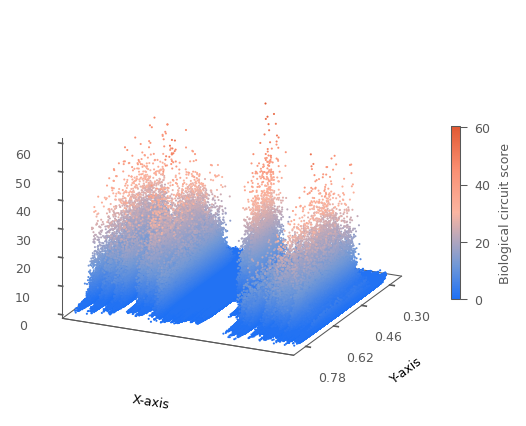

In [57]:
if plotting:

    # === Style params you can tweak ===
    AXIS_HEX    = "#585858"   # any hex color (e.g., "#FF0055")
    AXIS_ALPHA  = 1        # 0=transparent, 1=opaque for axis lines & ticks
    LINEWIDTH   = 0.5         # axis, pane edge, and tick width

    # Convert once, reuse everywhere
    axis_rgba = mcolors.to_rgba(AXIS_HEX, AXIS_ALPHA)  # for axis lines & tick marks
    edge_rgba = mcolors.to_rgba(AXIS_HEX, 1.0)         # pane edge drawn fully opaque

    # Set plot parameters
    plt.rcParams.update({
        "font.size": 6, "axes.titlesize": 6, "axes.labelsize": 6,
        "legend.fontsize": 6, "xtick.labelsize": 6, "ytick.labelsize": 6,
        "pdf.fonttype": 42,           # embed TrueType so text stays editable in Illustrator
        "ps.fonttype": 42,            # same for EPS (if you ever export EPS)
        "pdf.use14corefonts": False,  # allow embedding non-core fonts
        "svg.fonttype": "none",  
    })

    # Create figure and 3D axes
    fig = plt.figure(figsize=(pt_to_in(270), pt_to_in(270)), dpi=150)
    ax = fig.add_subplot(111, projection="3d")

    # --- The Definitive Solution using zorder ---
    ax.grid(False)

    # Draw the floor pane edge on top
    ax.zaxis.pane.set_zorder(10)
    ax.zaxis.pane.set_alpha(1.0)
    ax.zaxis.pane.set_edgecolor(edge_rgba)
    ax.zaxis.pane.set_linewidth(LINEWIDTH)

    # Make side panes invisible
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')

    coldest   = "#1D70F6"   
    cold   = "#7399D6"   
    middle = "#FBB5A1"   
    warm   = "#FA8F72"   
    warmest   = "#E15832" 

    cw_mid = mcolors.LinearSegmentedColormap.from_list(
        "coolwarm_mid",
        [(0.00, coldest),
        (0.20, cold),
        (0.50, middle),
        (0.75, warm),
        (1.00, warmest)],
        N=256)                     

    cmap = cw_mid                       
    norm = mcolors.Normalize(vmin=circ_pred_sub.min(), vmax=circ_pred_sub.max())

    mask = circ_pred_sub >= 0
    x_pos   = idx_sub[mask]
    y_pos   = tox_pred_sub[mask]
    z_pos   = circ_pred_sub[mask]

    ax.scatter(
        x_pos, y_pos, z_pos, s=1,
        c=circ_pred_sub[mask], cmap=cw_mid, norm=norm,
        alpha=1, edgecolors="none", rasterized=True, label="Predicted"
    )


    ax.zaxis._axinfo["juggled"] = (1, 2, 0)

    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")


    # Axis line styles (x, y, z)
    for a in (ax.xaxis, ax.yaxis, ax.zaxis):
        a.line.set_color(axis_rgba)
        a.line.set_linewidth(LINEWIDTH)

    # Tick marks: same color & width on all three axes
    for axis in ('x', 'y', 'z'):
        ax.tick_params(axis=axis, which='both', width=LINEWIDTH, color=axis_rgba)

    # (Optional) If you also want tick LABELS to match the color:
    for axis in ('x', 'y', 'z'):
        ax.tick_params(axis=axis, which='both', width=LINEWIDTH, colors=axis_rgba)

    # Circuit score
    ax.zaxis._axinfo["tick"]["inward_factor"]  = 0.02
    ax.zaxis._axinfo["tick"]["outward_factor"] = 0.2

    # Permutations
    ax.xaxis._axinfo["tick"]["outward_factor"] = -0.2
    ax.xaxis.set_tick_params(direction="out")

    # Toxicity
    ax.yaxis._axinfo["tick"]["inward_factor"]  = -0.0
    ax.yaxis._axinfo["tick"]["outward_factor"] = -0.25
    ax.yaxis.set_tick_params(direction="out")

    # ---- Colorbar (scale bar) styled to match ----
    mappable = cm.ScalarMappable(norm=norm, cmap=cmap)  # assumes you have `cm` and `cmap` defined elsewhere
    cbar = fig.colorbar(
        mappable, ax=ax,
        fraction=0.03, pad=0.06, shrink=0.4, aspect=20
    )

    # Outline/border
    cbar.outline.set_edgecolor(axis_rgba)
    cbar.outline.set_linewidth(LINEWIDTH)

    # Tick marks & tick labels
    cbar.ax.tick_params(which='both', width=LINEWIDTH, color=axis_rgba, colors=axis_rgba)

    # Label (text) color
    cbar.set_label("Biological circuit score", fontsize=6, color=axis_rgba)




    def limits_with_pad(data, frac):
        data = np.asarray(data)
        lo = float(np.nanmin(data))
        hi = float(np.nanmax(data))
        span = hi - lo
        if span <= 0:
            # Constant data: pad relative to magnitude (or small absolute pad)
            base = max(abs(hi), 1.0)
            pad = base * frac
            return lo - pad, hi + pad
        pad = span * frac
        return lo - pad, hi + pad

    EDGE_PAD_FRAC_X = 0.0
    EDGE_PAD_FRAC_Y = 0.0  
    EDGE_PAD_FRAC_Z = 0.0  

    xlim = limits_with_pad(x_pos, EDGE_PAD_FRAC_X)
    ylim = limits_with_pad(y_pos, EDGE_PAD_FRAC_Y)
    zlim = limits_with_pad(z_pos, EDGE_PAD_FRAC_Z)

    zlim = (0, zlim[1]) 
    ax.set_xlim(*xlim); 
    ax.set_ylim(*ylim); 
    ax.set_zlim(*zlim)


    #to delete the permutation tick marks and text
    ax.set_xticks([])

    # === Exactly 4 Y major ticks with balanced edge gaps ===
    N_YTICKS = 4
    Y_BORDER_RATIO = 0.35  # 1.0 = border gap equals interior spacing; 0.0 = ticks on borders

    y0, y1 = ax.get_ylim()  # after autoscale
    d_y = (y1 - y0) / (N_YTICKS - 1 + 2*Y_BORDER_RATIO)  # interior spacing
    g_y = Y_BORDER_RATIO * d_y                            # border gap size
    y_ticks = y0 + g_y + d_y * np.arange(N_YTICKS)

    ax.yaxis.set_major_locator(FixedLocator(y_ticks))
    ax.yaxis.set_minor_locator(FixedLocator([]))  # ensure no extra minor ticks
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


    plt.rcParams['svg.fonttype'] = 'none'   # for SVG
    plt.rcParams['pdf.fonttype'] = 42       # for PDF (TrueType)

    ax.view_init(elev=20, azim=115)

    ax.set_proj_type("ortho")

# (Optional) Zoom the camera a bit (works in many Matplotlib versions)

#plot_path = Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/composition_to_function_{circuit_name}_{selected_graph}_{permutation_index}.pdf"
#fig.savefig(plot_path, dpi=300, bbox_inches="tight", pad_inches=0.02)


In [58]:
if plotting:
    fig.savefig(Path(output_dir) /f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/comp_to_function_{circuit_name}_{selected_graph}_{permutation_index}.pdf", dpi=300, bbox_inches="tight")

In [ ]:
#stop

In [ ]:
if plotting:
    #pt_to_in = lambda pt: pt / 72

    # === Style params you can tweak ===
    AXIS_HEX    = "#585858"   # any hex color (e.g., "#FF0055")
    AXIS_ALPHA  = 1        # 0=transparent, 1=opaque for axis lines & ticks
    LINEWIDTH   = 0.5         # axis, pane edge, and tick width

    # Convert once, reuse everywhere
    axis_rgba = mcolors.to_rgba(AXIS_HEX, AXIS_ALPHA)  # for axis lines & tick marks
    edge_rgba = mcolors.to_rgba(AXIS_HEX, 1.0)         # pane edge drawn fully opaque

    # Set plot parameters
    plt.rcParams.update({
        "font.size": 6, "axes.titlesize": 6, "axes.labelsize": 6,
        "legend.fontsize": 6, "xtick.labelsize": 6, "ytick.labelsize": 6,
        "pdf.fonttype": 42,           # embed TrueType so text stays editable in Illustrator
        "ps.fonttype": 42,            # same for EPS (if you ever export EPS)
        "pdf.use14corefonts": False,  # allow embedding non-core fonts
        "svg.fonttype": "none",  
    })

    # Create figure and 3D axes
    fig = plt.figure(figsize=(pt_to_in(270), pt_to_in(270)), dpi=150)
    ax = fig.add_subplot(111, projection="3d")

    # --- The Definitive Solution using zorder ---
    ax.grid(False)

    # Draw the floor pane edge on top
    ax.zaxis.pane.set_zorder(10)
    ax.zaxis.pane.set_alpha(1.0)
    ax.zaxis.pane.set_edgecolor(edge_rgba)
    ax.zaxis.pane.set_linewidth(LINEWIDTH)

    # Make side panes invisible
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')

    coldest   = "#1D70F6"   
    cold   = "#7399D6"   
    middle = "#FBB5A1"   
    warm   = "#FA8F72"   
    warmest   = "#E15832" 

    cw_mid = mcolors.LinearSegmentedColormap.from_list(
        "coolwarm_mid",
        [(0.00, coldest),
        (0.20, cold),
        (0.50, middle),
        (0.75, warm),
        (1.00, warmest)],
        N=256)                     

    cmap = cw_mid                       
    norm = mcolors.Normalize(vmin=circ_pred_sub.min(), vmax=circ_pred_sub.max())

    mask = circ_pred_sub >= 0
    x_pos   = idx_sub[mask]
    y_pos   = tox_pred_sub[mask]
    z_pos   = circ_pred_sub[mask]

    ax.scatter(
        x_pos, y_pos, z_pos, s=2,
        c=circ_pred_sub[mask], cmap=cw_mid, norm=norm,
        alpha=1, edgecolors="none", rasterized=True, label="Predicted"
    )


    ax.zaxis._axinfo["juggled"] = (1, 2, 0)

    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")


    # Axis line styles (x, y, z)
    for a in (ax.xaxis, ax.yaxis, ax.zaxis):
        a.line.set_color(axis_rgba)
        a.line.set_linewidth(LINEWIDTH)

    # Tick marks: same color & width on all three axes
    for axis in ('x', 'y', 'z'):
        ax.tick_params(axis=axis, which='both', width=LINEWIDTH, color=axis_rgba)

    # (Optional) If you also want tick LABELS to match the color:
    for axis in ('x', 'y', 'z'):
        ax.tick_params(axis=axis, which='both', width=LINEWIDTH, colors=axis_rgba)

    # Circuit score
    ax.zaxis._axinfo["tick"]["inward_factor"]  = 0.02
    ax.zaxis._axinfo["tick"]["outward_factor"] = 0.2

    # Permutations
    ax.xaxis._axinfo["tick"]["outward_factor"] = -0.2
    ax.xaxis.set_tick_params(direction="out")

    # Toxicity
    ax.yaxis._axinfo["tick"]["inward_factor"]  = -0.0
    ax.yaxis._axinfo["tick"]["outward_factor"] = -0.25
    ax.yaxis.set_tick_params(direction="out")

    # ---- Colorbar (scale bar) styled to match ----
    mappable = cm.ScalarMappable(norm=norm, cmap=cmap)  # assumes you have `cm` and `cmap` defined elsewhere
    cbar = fig.colorbar(
        mappable, ax=ax,
        fraction=0.03, pad=0.06, shrink=0.4, aspect=20
    )

    # Outline/border
    cbar.outline.set_edgecolor(axis_rgba)
    cbar.outline.set_linewidth(LINEWIDTH)

    # Tick marks & tick labels
    cbar.ax.tick_params(which='both', width=LINEWIDTH, color=axis_rgba, colors=axis_rgba)

    # Label (text) color
    cbar.set_label("Biological circuit score", fontsize=6, color=axis_rgba)




    def limits_with_pad(data, frac):
        data = np.asarray(data)
        lo = float(np.nanmin(data))
        hi = float(np.nanmax(data))
        span = hi - lo
        if span <= 0:
            # Constant data: pad relative to magnitude (or small absolute pad)
            base = max(abs(hi), 1.0)
            pad = base * frac
            return lo - pad, hi + pad
        pad = span * frac
        return lo - pad, hi + pad

    EDGE_PAD_FRAC_X = 0.0
    EDGE_PAD_FRAC_Y = 0.0  
    EDGE_PAD_FRAC_Z = 0.0  

    xlim = limits_with_pad(x_pos, EDGE_PAD_FRAC_X)
    ylim = limits_with_pad(y_pos, EDGE_PAD_FRAC_Y)
    zlim = limits_with_pad(z_pos, EDGE_PAD_FRAC_Z)

    zlim = (0, zlim[1]) 
    ax.set_xlim(*xlim); 
    ax.set_ylim(*ylim); 
    ax.set_zlim(*zlim)


    #to delete the permutation tick marks and text
    ax.set_xticks([])

    # === Exactly 4 Y major ticks with balanced edge gaps ===
    N_YTICKS = 4
    Y_BORDER_RATIO = 0.35  # 1.0 = border gap equals interior spacing; 0.0 = ticks on borders

    y0, y1 = ax.get_ylim()  # after autoscale
    d_y = (y1 - y0) / (N_YTICKS - 1 + 2*Y_BORDER_RATIO)  # interior spacing
    g_y = Y_BORDER_RATIO * d_y                            # border gap size
    y_ticks = y0 + g_y + d_y * np.arange(N_YTICKS)

    ax.yaxis.set_major_locator(FixedLocator(y_ticks))
    ax.yaxis.set_minor_locator(FixedLocator([]))  # ensure no extra minor ticks
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


    plt.rcParams['svg.fonttype'] = 'none'   # for SVG
    plt.rcParams['pdf.fonttype'] = 42       # for PDF (TrueType)

    ax.view_init(elev=90, azim=0, roll = 90)

    ax.set_proj_type("ortho")

    y_thresh = growth_score_threshold
    ax.plot(
        [xlim[0], xlim[1]],   # span full X range
        [y_thresh, y_thresh], # constant Y
        [zlim[0], zlim[0]],   # sit on the "floor" (z=0)
        color=axis_rgba, linewidth=1.0, alpha=1.0, zorder=20
    )


    # (Optional) Zoom the camera a bit (works in many Matplotlib versions)

    #plot_path = Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/composition_to_function_{circuit_name}_{selected_graph}_{permutation_index}.pdf"
    #fig.savefig(plot_path, dpi=300, bbox_inches="tight", pad_inches=0.02)


In [ ]:
if plotting:
    fig.savefig(Path(output_dir) /f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/comp_to_function_2D_1_{circuit_name}_{selected_graph}_{permutation_index}.pdf", dpi=300, bbox_inches="tight")

In [ ]:
if plotting:
    #pt_to_in = lambda pt: pt / 72

    # === Style params you can tweak ===
    AXIS_HEX    = "#585858"   # any hex color (e.g., "#FF0055")
    AXIS_ALPHA  = 1        # 0=transparent, 1=opaque for axis lines & ticks
    LINEWIDTH   = 0.5         # axis, pane edge, and tick width

    # Convert once, reuse everywhere
    axis_rgba = mcolors.to_rgba(AXIS_HEX, AXIS_ALPHA)  # for axis lines & tick marks
    edge_rgba = mcolors.to_rgba(AXIS_HEX, 1.0)         # pane edge drawn fully opaque

    # Set plot parameters
    plt.rcParams.update({
        "font.size": 6, "axes.titlesize": 6, "axes.labelsize": 6,
        "legend.fontsize": 6, "xtick.labelsize": 6, "ytick.labelsize": 6,
        "pdf.fonttype": 42,           # embed TrueType so text stays editable in Illustrator
        "ps.fonttype": 42,            # same for EPS (if you ever export EPS)
        "pdf.use14corefonts": False,  # allow embedding non-core fonts
        "svg.fonttype": "none",      
    })

    # Create figure and 3D axes
    fig = plt.figure(figsize=(pt_to_in(270), pt_to_in(270)), dpi=150)
    ax = fig.add_subplot(111, projection="3d")

    # --- The Definitive Solution using zorder ---
    ax.grid(False)

    # Draw the floor pane edge on top
    ax.zaxis.pane.set_zorder(10)
    ax.zaxis.pane.set_alpha(1.0)
    ax.zaxis.pane.set_edgecolor(edge_rgba)
    ax.zaxis.pane.set_linewidth(LINEWIDTH)

    # Make side panes invisible
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')

    coldest   = "#1D70F6"   
    cold   = "#7399D6"   
    middle = "#FBB5A1"   
    warm   = "#FA8F72"   
    warmest   = "#E15832" 

    cw_mid = mcolors.LinearSegmentedColormap.from_list(
        "coolwarm_mid",
        [(0.00, coldest),
        (0.20, cold),
        (0.50, middle),
        (0.75, warm),
        (1.00, warmest)],
        N=256)                     

    cmap = cw_mid                       
    norm = mcolors.Normalize(vmin=circ_pred_sub.min(), vmax=circ_pred_sub.max())

    mask = circ_pred_sub >= 0
    x_pos   = idx_sub[mask]
    y_pos   = tox_pred_sub[mask]
    z_pos   = circ_pred_sub[mask]

    ax.scatter(
        x_pos, y_pos, z_pos, s=1,
        c=circ_pred_sub[mask], cmap=cw_mid, norm=norm,
        alpha=1, edgecolors="none", rasterized=True, label="Predicted"
    )


    ax.zaxis._axinfo["juggled"] = (1, 2, 0)

    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")


    # Axis line styles (x, y, z)
    for a in (ax.xaxis, ax.yaxis, ax.zaxis):
        a.line.set_color(axis_rgba)
        a.line.set_linewidth(LINEWIDTH)

    # Tick marks: same color & width on all three axes
    for axis in ('x', 'y', 'z'):
        ax.tick_params(axis=axis, which='both', width=LINEWIDTH, color=axis_rgba)

    # (Optional) If you also want tick LABELS to match the color:
    for axis in ('x', 'y', 'z'):
        ax.tick_params(axis=axis, which='both', width=LINEWIDTH, colors=axis_rgba)

    # Circuit score
    ax.zaxis._axinfo["tick"]["inward_factor"]  = 0.02
    ax.zaxis._axinfo["tick"]["outward_factor"] = 0.2

    # Permutations
    ax.xaxis._axinfo["tick"]["outward_factor"] = -0.2
    ax.xaxis.set_tick_params(direction="out")

    # Toxicity
    ax.yaxis._axinfo["tick"]["inward_factor"]  = -0.0
    ax.yaxis._axinfo["tick"]["outward_factor"] = -0.25
    ax.yaxis.set_tick_params(direction="out")

    # ---- Colorbar (scale bar) styled to match ----
    mappable = cm.ScalarMappable(norm=norm, cmap=cmap)  # assumes you have `cm` and `cmap` defined elsewhere
    cbar = fig.colorbar(
        mappable, ax=ax,
        fraction=0.03, pad=0.06, shrink=0.4, aspect=20
    )

    # Outline/border
    cbar.outline.set_edgecolor(axis_rgba)
    cbar.outline.set_linewidth(LINEWIDTH)

    # Tick marks & tick labels
    cbar.ax.tick_params(which='both', width=LINEWIDTH, color=axis_rgba, colors=axis_rgba)

    # Label (text) color
    cbar.set_label("Biological circuit score", fontsize=6, color=axis_rgba)




    def limits_with_pad(data, frac):
        data = np.asarray(data)
        lo = float(np.nanmin(data))
        hi = float(np.nanmax(data))
        span = hi - lo
        if span <= 0:
            # Constant data: pad relative to magnitude (or small absolute pad)
            base = max(abs(hi), 1.0)
            pad = base * frac
            return lo - pad, hi + pad
        pad = span * frac
        return lo - pad, hi + pad

    EDGE_PAD_FRAC_X = 0.0
    EDGE_PAD_FRAC_Y = 0.0  
    EDGE_PAD_FRAC_Z = 0.0  

    xlim = limits_with_pad(x_pos, EDGE_PAD_FRAC_X)
    ylim = limits_with_pad(y_pos, EDGE_PAD_FRAC_Y)
    zlim = limits_with_pad(z_pos, EDGE_PAD_FRAC_Z)

    zlim = (0, zlim[1]) 
    ax.set_xlim(*xlim); 
    ax.set_ylim(*ylim); 
    ax.set_zlim(*zlim)


    #to delete the permutation tick marks and text
    ax.set_xticks([])

    # === Exactly 4 Y major ticks with balanced edge gaps ===
    N_YTICKS = 4
    Y_BORDER_RATIO = 0.35  # 1.0 = border gap equals interior spacing; 0.0 = ticks on borders

    y0, y1 = ax.get_ylim()  # after autoscale
    d_y = (y1 - y0) / (N_YTICKS - 1 + 2*Y_BORDER_RATIO)  # interior spacing
    g_y = Y_BORDER_RATIO * d_y                            # border gap size
    y_ticks = y0 + g_y + d_y * np.arange(N_YTICKS)

    ax.yaxis.set_major_locator(FixedLocator(y_ticks))
    ax.yaxis.set_minor_locator(FixedLocator([]))  # ensure no extra minor ticks
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


    plt.rcParams['svg.fonttype'] = 'none'   # for SVG
    plt.rcParams['pdf.fonttype'] = 42       # for PDF (TrueType)

    ax.view_init(elev=0, azim=90, roll = 0)

    ax.set_proj_type("ortho")

    # (Optional) Zoom the camera a bit (works in many Matplotlib versions)

    #plot_path = Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/composition_to_function_{circuit_name}_{selected_graph}_{permutation_index}.pdf"
    #fig.savefig(plot_path, dpi=300, bbox_inches="tight", pad_inches=0.02)


In [ ]:
if plotting:
    fig.savefig(Path(output_dir) /f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/comp_to_function_2D_2_{circuit_name}_{selected_graph}_{permutation_index}.pdf", dpi=300, bbox_inches="tight")

## Find top designs

#### Filter condition is where predicted circuit score is above a threshold

In [59]:
circuit_score_threshold = 2
filter_condition_for_circuit_score = y_predicted_circuit_scores >= circuit_score_threshold
(y_predicted_circuit_scores >= circuit_score_threshold).sum()

700710

In [60]:
len(filter_condition_for_circuit_score)

72999360

#### Filter condition is where predicted toxicity score is above a threshold

In [61]:
toxicity_score_threshold = 0.5
filter_condition_for_toxicty_score = y_predicted_toxicity_scores >= toxicity_score_threshold
(y_predicted_toxicity_scores >= toxicity_score_threshold).sum()

30294730

In [62]:
len(filter_condition_for_toxicty_score)

72999360

#### Select and save permutations predicted to be high-performing

In [63]:
mask_both_circuit_and_tox_score = filter_condition_for_circuit_score & filter_condition_for_toxicty_score
idx_predicted_to_have_high_scores = np.flatnonzero(mask_both_circuit_and_tox_score)

In [64]:
len(idx_predicted_to_have_high_scores)

234770

In [65]:
X_valid_permutations = np.array(valid_permutations)
method_1_result = X_valid_permutations[idx_predicted_to_have_high_scores]

In [66]:
method_2_result = X_valid_permutations_tensor.cpu().numpy()[idx_predicted_to_have_high_scores]

In [67]:
# shapes the same?
assert method_1_result.shape == method_2_result.shape

# exact values the same?
assert np.array_equal(method_1_result, method_2_result)

# (optional) also require same dtype:
assert method_1_result.dtype == method_2_result.dtype

In [69]:
#gate_assignments_predicted_to_have_high_scores = X_valid_permutations[idx_predicted_to_have_high_scores]

#alternative method
gate_assignments_predicted_to_have_high_scores = X_valid_permutations_tensor.cpu().numpy()[idx_predicted_to_have_high_scores]

print(len(gate_assignments_predicted_to_have_high_scores))
# Save the array

#np.save(Path(output_dir)/ f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/gate_assignments_predicted_to_have_high_scores_{circuit_name}_{selected_graph}_{permutation_index}.npy", gate_assignments_predicted_to_have_high_scores)

np.save(Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/" \
       f"gate_assignments_predicted_to_have_high_scores_{circuit_name}_{selected_graph}_{permutation_index}.npy",
       gate_assignments_predicted_to_have_high_scores)

234770


#### Load permutations predicted to be high-performing

In [70]:
gate_assignments_predicted_to_have_high_scores = np.load(Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/gate_assignments_predicted_to_have_high_scores_{circuit_name}_{selected_graph}_{permutation_index}.npy")

# Convert to list of tuples
gate_assignments_predicted_to_have_high_scores_list_of_tuples = [
    tuple(np.int64(x) for x in tup) 
    for tup in gate_assignments_predicted_to_have_high_scores
]


In [71]:
len(gate_assignments_predicted_to_have_high_scores)

234770

#### Calculate actual scores and save

In [72]:
# Initialize your graph and get adjacency matrix
Gi = permuted_graphs[permutation_index]
nodelist = sorted(Gi.nodes())
adj_matrix_sparse = nx.adjacency_matrix(Gi, nodelist=nodelist)
adj_matrix = adj_matrix_sparse.toarray()

# Run parallel processing with custom file size
results_summary = parallel_process_circuits(
    adj_matrix=adj_matrix,
    valid_permutations=gate_assignments_predicted_to_have_high_scores_list_of_tuples,
    experimental_params=postech_v1_hill_function_parameters,
    input_signals_small=input_signals_list_small_molecules,
    input_signals_binary=input_signals_list_binary,
    gate_toxicity_df=gate_toxicity_df,
    output_dir=Path(output_dir)/ f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/scores_of_designs_predicted_to_have_high_scores_{circuit_name}_{selected_graph}_{permutation_index}",
    num_samples=len(gate_assignments_predicted_to_have_high_scores_list_of_tuples),           # Total solutions to process
    batch_size=batch_size,              # Size of each processing batch
    solutions_per_file=solutions_per_file,     # Save every 500,000 solutions
    num_cores = CPUs_alloc
    )

Utilizing all 80 cores for parallel processing
Solutions per file: 234,770
Expected number of files: 1
Selecting 234,770 random solutions from 234,770 valid permutations
Processing 235 batches using 80 cores


Processing batches:  99%|▉| 233/235 [02:07<00:01,  1.85batch/s, Solutions=233,770/234,770, Elapsed=2.4m


Saving file 0 with 234,770 solutions...


Processing batches: 100%|█| 235/235 [02:11<00:00,  1.79batch/s, Solutions=234,770/234,770, Elapsed=2.4m

Successfully saved 234,770 solutions to /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/stratch/0x6D_design_0_permutation_0/scores_of_designs_predicted_to_have_high_scores_0x6D_0_0/results_large_batch_0.pkl



Processing completed!
Total solutions processed: 234,770
Total time: 2.5 minutes
Average processing speed: 1585.7 solutions/second
Total files created: 1


#### Load actual scores if saved

In [73]:
# Load all results
(permutations_high_performing, toxicity_scores_high_performing, 
 circuit_scores_high_performing, roadblocking_flags_high_performing) = load_circuit_results( Path(output_dir)/ f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/scores_of_designs_predicted_to_have_high_scores_{circuit_name}_{selected_graph}_{permutation_index}")

if len(permutations) > 0:
    # Print data shape summary
    print("\nData shape summary:")
    print(f"Permutations shape: {permutations_high_performing.shape}")
    print(f"Toxicity scores shape: {toxicity_scores_high_performing.shape}")
    print(f"Circuit scores shape: {circuit_scores_high_performing.shape}")
    print(f"Roadblocking flags shape: {roadblocking_flags_high_performing.shape}")

Found 1 batch files to load


Loading results: 100%|███████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.59s/it]



Loading completed:
Total results loaded: 234,770
Unique permutations: 234,770
Average circuit score: 4.178
Average toxicity score: 0.581
Roadblocking percentage: 98.4%

Data shape summary:
Permutations shape: (234770, 7)
Toxicity scores shape: (234770,)
Circuit scores shape: (234770,)
Roadblocking flags shape: (234770,)


### List top biological designs 

In [74]:
no_roadblock_mask = ~roadblocking_flags_high_performing

In [75]:
permutations_high_performing_no_roadblocking = permutations_high_performing[no_roadblock_mask]
circuit_scores_high_performing_no_roadblocking = circuit_scores_high_performing[no_roadblock_mask]
toxicity_scores_high_performing_no_roadblocking = toxicity_scores_high_performing[no_roadblock_mask]
roadblocking_flags_high_performing_no_roadblocking = roadblocking_flags_high_performing[no_roadblock_mask]

In [76]:
toxicity_filter = toxicity_scores_high_performing_no_roadblocking >= growth_score_threshold

In [77]:
permutations_high_performing_no_roadblocking_toxicity_filtered = permutations_high_performing_no_roadblocking[toxicity_filter]
circuit_scores_high_performing_no_roadblocking_toxicity_filtered = circuit_scores_high_performing_no_roadblocking[toxicity_filter]
toxicity_scores_high_performing_no_roadblocking_toxicity_filtered = toxicity_scores_high_performing_no_roadblocking[toxicity_filter]
roadblocking_flags_high_performing_no_roadblocking_toxicity_filtered = roadblocking_flags_high_performing_no_roadblocking[toxicity_filter]

In [78]:
print(circuit_scores_high_performing_no_roadblocking_toxicity_filtered)

[1.90521123 2.06050151 2.73762629 2.83231944 2.27833741 2.77932386
 3.380272   2.9166007  3.02320321 2.14536267 3.00360327 3.9454699
 2.72919592 3.77346757 2.72544252 2.78117538 2.77937246 1.54031447
 2.21434221 4.56519422 2.09444618 2.75022697 2.09572463 1.79391852
 3.29884659 1.94761185 3.48048057 2.90970484 1.77024543 2.24031607
 4.43198354 3.14463043 3.73261129 1.56792225 3.33070401 2.33164212
 3.01155874 2.64053298 2.61864155 3.18266563 1.9050587  3.40397797
 2.54232025 2.85631128 2.27993772 2.63611747 2.55802804 1.73692629
 2.17956607 1.96057349 2.07097522 2.39490009 2.83002428 2.97374454
 2.17266914 1.76176061 2.52631146 2.0867495  2.36222531 2.629821
 5.20865207 3.78546343 2.42748831 2.1776315  4.15032545 2.69143904
 1.72443557 2.17693021 2.78718963 1.6713496  1.82141877 2.60210099
 2.00652985 2.42043236 4.41570864 2.64874763 2.06614303 3.23301549
 2.80767558 2.93240719 3.84556593 2.68568436 2.25752394 2.32968539
 4.75111541 3.03256042 1.54238812 9.23817343 2.69878755 2.1827136

In [79]:
permutations_high_performing_no_roadblocking_toxicity_filtered.shape

(363, 7)

In [80]:
circuit_scores_high_performing_no_roadblocking_toxicity_filtered.shape

(363,)

In [ ]:
if plotting:

    plt.rcParams.update({
        "font.size": 6, "axes.titlesize": 6, "axes.labelsize": 6,
        "legend.fontsize": 6, "xtick.labelsize": 6, "ytick.labelsize": 6,
        "pdf.fonttype": 42,           # embed TrueType so text stays editable in Illustrator
        "ps.fonttype": 42,            # same for EPS (if you ever export EPS)
        "pdf.use14corefonts": False,  # allow embedding non-core fonts
        "svg.fonttype": "none",  
    })

    edge_col, edge_w = "#58595B", 0.5
    pt_to_in = lambda pt: pt / 72

    # toxicity threshold 
    tox_thr = growth_score_threshold                      

    # pick all high-performing samples 
    tox_all   = toxicity_scores_high_performing
    circ_all  = circuit_scores_high_performing
    flags_all = roadblocking_flags_high_performing       # booleans

    # build a mask on this full set 
    toxicity_filter = tox_all >= tox_thr                 

    # apply it once
    tox   = tox_all[toxicity_filter]
    circ  = circ_all[toxicity_filter]
    flags = flags_all[toxicity_filter]       # keeps both True and False

    # compute the Pareto front 
    order      = np.argsort(tox)           
    best_circ  = -np.inf
    pareto_idx = []
    for i in order:
        if circ[i] > best_circ:
            pareto_idx.append(i)
            best_circ = circ[i]

    pareto_mask          = np.zeros_like(circ, dtype=bool)
    pareto_mask[pareto_idx] = True          # True → on Pareto front

    # color: red = road-blocking, blue = valid 
    color_map = np.where(flags, "red", "blue")

    # plot 

    # Create a figure with 2 subplots (1 row, 2 columns)
    # Adjusted figsize and dpi to match the reference code's aesthetic
    fig, (ax_left, ax_right) = plt.subplots(
        1, 2,
        figsize=(pt_to_in(270*.7), pt_to_in(135*.7)), # Adjusted for a 2:1 aspect ratio, similar to reference
        dpi=250, # Increased DPI
        sharex=True, sharey=True # Keeping shared axes for better comparison
    )
    fig.subplots_adjust(wspace=0.30) # Added wspace from reference code

    # Plotting for the Left Subplot (Blue Dots - Clear) 
    # Filter data for blue dots
    blue_mask = (color_map == "blue")
    tox_blue = tox[blue_mask]
    circ_blue = circ[blue_mask]
    pareto_mask_blue = pareto_mask[blue_mask]

    # Plot non-Pareto blue dots with styling from reference
    ax_left.scatter(tox_blue[~pareto_mask_blue], circ_blue[~pareto_mask_blue],
            s=4, c="blue", alpha=1, edgecolors="none", rasterized=False)

    # Plot Pareto blue dots (now styled like non-Pareto points, no highlight)
    ax_left.scatter(tox_blue[pareto_mask_blue], circ_blue[pareto_mask_blue],
            s=4, c="blue", alpha=1,
            edgecolors="none", rasterized=False) # Removed edgecolors="k", linewidths=.4, and label="Pareto front"

    ax_left.set_xlabel("Toxicity score (lower = better)", labelpad=4) # Added labelpad
    ax_left.set_ylabel("Circuit score (higher = better)", labelpad=4) # Added labelpad
    ax_left.set_title("Clear Candidates (Blue Dots)")
    # Removed legend as Pareto front is no longer explicitly labeled
    # ax_left.legend(frameon=False, loc="upper left", markerscale=5)


    # Plotting for the Right Subplot (Red Dots - Road-blocking)
    # Filter data for red dots
    red_mask = (color_map == "red")
    tox_red = tox[red_mask]
    circ_red = circ[red_mask]
    pareto_mask_red = pareto_mask[red_mask]

    # Plot non-Pareto red dots with styling from reference
    ax_right.scatter(tox_red[~pareto_mask_red], circ_red[~pareto_mask_red],
            s=4, c="red", alpha=1, edgecolors="none", rasterized=False)

    # Plot Pareto red dots 
    ax_right.scatter(tox_red[pareto_mask_red], circ_red[pareto_mask_red],
            s=4, c="red", alpha=1,
            edgecolors="none", rasterized=False) # Removed edgecolors="k", linewidths=.4, and label="Pareto front"

    ax_right.set_xlabel("Toxicity score (higher = better)", labelpad=4) # Added labelpad
    ax_right.set_ylabel("Circuit score (higher = better)", labelpad=4) # Added labelpad
    ax_right.set_title("Road-blocking Candidates (Red Dots)")
    # Removed legend as Pareto front is no longer explicitly labeled
    # ax_right.legend(frameon=False, loc="upper left", markerscale=5)

    # Apply formatting 
    for ax in (ax_left, ax_right):
        for spine in ax.spines.values():
            spine.set_color(edge_col); spine.set_linewidth(edge_w)

        ax.tick_params(direction="out", length=4, width=edge_w,
                    colors=edge_col, pad=1)
        ax.xaxis.label.set_color(edge_col)
        ax.yaxis.label.set_color(edge_col)
        ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=8)) # Added MaxNLocator

    # Adjust layout to prevent overlapping parts
    plt.tight_layout()
    plt.show()


In [ ]:
if plotting:
    fig.savefig(Path(output_dir) /f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/actual_desings_selected_using_NN_{circuit_name}_{selected_graph}_{permutation_index}.pdf", dpi=300, bbox_inches="tight")

### Select how many incoming signals according to repressor

In [81]:

#This excludes NOR BetI
'''
gate_max_incoming_signals = {
    "gate_max_incoming_signals": [2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 
            2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
}
'''

gate_max_incoming_signals = {
    "gate_max_incoming_signals": [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 
            2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
}

# Create DataFrame
gate_max_incoming_signals_df = pd.DataFrame(gate_max_incoming_signals)

In [82]:
valid_NOR_NOT_assignments_flags = []

for perm in (permutations_high_performing_no_roadblocking_toxicity_filtered):
    Gtest = assign_representations_with_io_nodes_3(adj_matrix, postech_v1_hill_function_parameters, perm)
    valid_NOR_NOT_assignments_flags.append(validate_graph_incoming_signals(Gtest, postech_v1_hill_function_parameters, gate_max_incoming_signals_df))

In [83]:
num_true = sum(valid_NOR_NOT_assignments_flags)
num_true

363

In [84]:
N = 20

In [85]:
# Get indices where validation flags are True
valid_indices = [i for i, flag in enumerate(valid_NOR_NOT_assignments_flags) if flag]

# Filter scores to only include valid circuits
top_n_indices = np.argsort([circuit_scores_high_performing_no_roadblocking_toxicity_filtered[i] for i in valid_indices])[-N:][::-1]
valid_indices_array = np.array(valid_indices)

print(f"\nTop {N} Valid Circuit Scores (no roadblocking, toxicity > {growth_score_threshold}:")
print("Rank | Circuit Score | Toxicity Score | Roadblocking | Permutation")
print("-" * 100)

highest_score_details = {}
for rank, idx in enumerate(top_n_indices, 1):
    corresponding_index = valid_indices_array[idx]
    best_permutation = permutations_high_performing_no_roadblocking_toxicity_filtered[corresponding_index]
    roadblock_flag = roadblocking_flags_high_performing_no_roadblocking_toxicity_filtered[corresponding_index]
    
    print(f"{rank:4d} | {circuit_scores_high_performing_no_roadblocking_toxicity_filtered[corresponding_index]:12.4f} | "
          f"{toxicity_scores_high_performing_no_roadblocking_toxicity_filtered[corresponding_index]:13.4f} | "
          f"{str(roadblock_flag):11} | {best_permutation}")
    
    if rank == 1:
        highest_score_details = {
            'circuit_score': circuit_scores_high_performing_no_roadblocking_toxicity_filtered[corresponding_index],
            'toxicity_score': toxicity_scores_high_performing_no_roadblocking_toxicity_filtered[corresponding_index],
            'roadblocking': roadblock_flag,
            'permutation': best_permutation
        }

print("\n" + "-"*100)
print("Detailed information for highest scoring valid design:")
print("-"*100)
print(f"Highest actual circuit score: {highest_score_details['circuit_score']}")
print(f"Corresponding actual toxicity score: {highest_score_details['toxicity_score']}")
print(f"Roadblocking: {highest_score_details['roadblocking']}")
print(f"Permutation: {highest_score_details['permutation']}")


Top 20 Valid Circuit Scores (no roadblocking, toxicity > 0.65:
Rank | Circuit Score | Toxicity Score | Roadblocking | Permutation
----------------------------------------------------------------------------------------------------
   1 |       9.2382 |        0.6759 | False       | [ 2  0  4  1 15 13 11]
   2 |       8.5414 |        0.6634 | False       | [ 2  0  5  1 15 13 11]
   3 |       8.0921 |        0.6744 | False       | [ 2  0  4  1 15 13 12]
   4 |       7.3062 |        0.6590 | False       | [ 2  0  5  1 15 13 12]
   5 |       7.1847 |        0.6726 | False       | [ 1  0 19  2 15 13 11]
   6 |       6.7409 |        0.6570 | False       | [ 2  0  4  1 19 13 11]
   7 |       6.4920 |        0.6515 | False       | [ 2  0  5  1 19 13 14]
   8 |       6.3258 |        0.6635 | False       | [13  2 11  0 15  1  4]
   9 |       6.2719 |        0.6667 | False       | [ 2  0  5  1 19 13 11]
  10 |       6.0734 |        0.6928 | False       | [ 1  0 19  2 15 13 12]
  11 |       5.693

In [86]:
G = assign_representations_with_io_nodes_3(adj_matrix, postech_v1_hill_function_parameters, highest_score_details['permutation'])


In [87]:
highest_performing_design = highest_score_details['permutation']   # your permutation (length L)
NUM_CLASSES = 20                  

# one-hot encode to shape [L, C], then flatten to [1, LxC]
idx = th.tensor(highest_performing_design, dtype=th.long)
oh  = th.nn.functional.one_hot(idx, num_classes=NUM_CLASSES).float().reshape(1, -1)

# predict circuit score 
device_c = next(model_circuit_score.parameters()).device
model_circuit_score.eval()
with th.no_grad():
    circuit_score_prediction = model_circuit_score(oh.to(device_c)).squeeze().item()
print(f"[circuit] prediction(highest_performing_design) = {circuit_score_prediction:.6f}")

# predict toxicity score
device_t = next(model_toxicity_score.parameters()).device
model_toxicity_score.eval()
with th.no_grad():
    toxicity_score_prediction = model_toxicity_score(oh.to(device_t)).squeeze().item()
print(f"[toxicity] prediction(highest_performing_design) = {toxicity_score_prediction:.6f}")

rows = [{
    "permutation": "-".join(map(str, highest_performing_design)),
    "circuit_score_pred": f"{circuit_score_prediction:.6f}",
    "toxicity_score_pred": f"{toxicity_score_prediction:.6f}",
}]


csv_path = Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/nn_prediction_of_highest_performing design__circuit_score_{circuit_name}_{selected_graph}_{permutation_index}.csv"
with open(csv_path, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
    writer.writeheader()
    writer.writerows(rows)
    
print(f"\n Saved {len(rows)} rows to {csv_path}")

[circuit] prediction(highest_performing_design) = 6.614463
[toxicity] prediction(highest_performing_design) = 0.667716

 Saved 1 rows to /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/stratch/0x6D_design_0_permutation_0/nn_prediction_of_highest_performing design__circuit_score_0x6D_0_0.csv


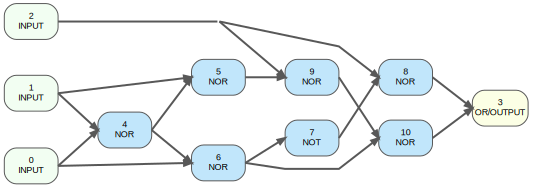

In [88]:
if plotting:
    plot_circuit_layered(
        G,
        outdir=Path(output_dir) /f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}",
        name=f'optimal_topology_{circuit_name}_{selected_graph}_{permutation_index}',
        fmt="svg",                   
        rankdir="LR",
        show_in_notebook=True,      
        compact=True,
        gv_size="8,4.5!",            
        gv_dpi=None,                 
        gv_margin="0.05",
        gv_pad="0.05"
    )
else:
    plot_circuit_layered(
        G,
        outdir=Path(output_dir) /f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}",
        name=f'optimal_topology_{circuit_name}_{selected_graph}_{permutation_index}',
        fmt="svg",                   
        rankdir="LR",
        show_in_notebook=False,      
        compact=True,
        gv_size="8,4.5!",            
        gv_dpi=None,                 
        gv_margin="0.05",
        gv_pad="0.05"
    )    



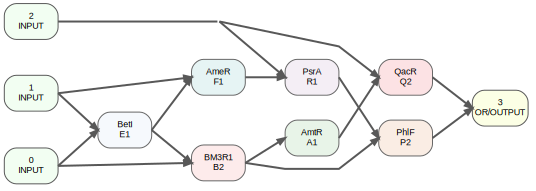

In [89]:
if plotting:
    plot_circuit_with_parts_layered(
        G,
        outdir=Path(output_dir) /f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}",
        name=f'optimal_topology_with_parts_assigned_{circuit_name}_{selected_graph}_{permutation_index}',
        fmt="svg",                   
        rankdir="LR",
        show_in_notebook=True,      
        compact=True,
        gv_size="8,4.5!",            
        gv_dpi=None,                 
        gv_margin="0.05",
        gv_pad="0.05"
    )
else:
    plot_circuit_with_parts_layered(
        G,
        outdir=Path(output_dir) /f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}",
        name=f'optimal_topology_with_parts_assigned_{circuit_name}_{selected_graph}_{permutation_index}',
        fmt="svg",                   
        rankdir="LR",
        show_in_notebook=False,      
        compact=True,
        gv_size="8,4.5!",            
        gv_dpi=None,                 
        gv_margin="0.05",
        gv_pad="0.05"
    )   

In [90]:
# Calculate toxicity
toxicity_score, _ = calculate_toxicity_score(
    input_signals_list_small_molecules,
    G,
    gate_toxicity_df
)

# Simulate logic
actual_logic = simulate_signal_propagation(
    G,
    input_signals_list_small_molecules
)
expected_logic = simulate_signal_propagation_binary(
    G,
    input_signals_list_binary
)

# Calculate scores
current_score = calculate_circuit_score(expected_logic, actual_logic)
roadblocking_flag = is_roadblocking(G)

print(f'Current score: {current_score}')
print(f'Toxicity score:{toxicity_score}')
print(f'Roadblocking: {roadblocking_flag}')



Current score: 9.238173429139644
Toxicity score:0.6759246276830934
Roadblocking: (False, [])


In [91]:
csv_path = Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/optimal_topology_with_parts_assigned_scores_{circuit_name}_{selected_graph}_{permutation_index}.csv"

with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Circuit score", "Toxicity score", "Roadblocking"])
    writer.writerow([float(current_score), float(toxicity_score),roadblocking_flag[0]])

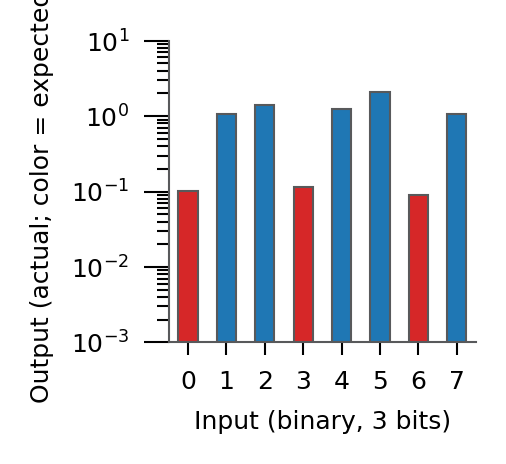

In [92]:


if plotting:
    plt.rcParams.update({
        "font.size": 6, "axes.titlesize": 6, "axes.labelsize": 6,
        "legend.fontsize": 6, "xtick.labelsize": 6, "ytick.labelsize": 6,
        "pdf.fonttype": 42,           # embed TrueType so text stays editable in Illustrator
        "ps.fonttype": 42,            # same for EPS (if you ever export EPS)
        "pdf.use14corefonts": False,  # allow embedding non-core fonts
        "svg.fonttype": "none",      
    })
    edge_col, edge_w = "#58595B", 0.5
    pt_to_in = lambda pt: pt / 72  # helper if you want to size in points

    # --- Data prep (list of dicts for outputs) ---
    # actual_logic = [{3: ...}, ...]
    # expected_logic = [{3: ...}, ...]  # same length/order as actual_logic
    values_actual = [next(iter(d.values())) for d in actual_logic]
    values_expected = [next(iter(d.values())) for d in expected_logic]

    n = len(values_actual)
    n_inputs = max(1, math.ceil(math.log2(n)))
    labels = [format(i, f'0{n_inputs}b') for i in range(n)]
    x = np.arange(n)

    # Colors determined by expected outputs (blue = high, red = low)
    threshold = 1.0  # if expected are 0/1, you might use 0.5
    colors = ["tab:blue" if v >= threshold else "tab:red" for v in values_expected]

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(pt_to_in(120), pt_to_in(110)), dpi=300)

    ax.bar(x, values_actual, width=0.5, color=colors, edgecolor=edge_col, linewidth=edge_w)

    ax.set_yscale("log")
    ax.set_ylim(1e-3, 1e1)
    ax.set_xlim(-0.5, n - 0.5)

    ax.set_xticks(x)
    # ax.set_xticklabels(labels)

    # Make major y-ticks (with labels) longer; keep minor shorter
    ax.tick_params(axis="y", which="major", width=edge_w, length=6)
    ax.tick_params(axis="y", which="minor", width=edge_w, length=3)
    ax.tick_params(axis="x", which="both", width=edge_w, length=3)

    # Spine styling
    for s in ["left", "bottom"]:
        ax.spines[s].set_linewidth(edge_w)
        ax.spines[s].set_color(edge_col)
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)

    ax.set_xlabel(f"Input (binary, {n_inputs} bits)")
    ax.set_ylabel("Output (actual; color = expected)")

    fig.tight_layout()
    plt.show()

In [93]:
if plotting:
    fig.savefig(Path(output_dir) /f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/optimal_design_simulation_{circuit_name}_{selected_graph}_{permutation_index}.pdf", dpi=300, bbox_inches="tight")

In [94]:
actual_logic

[{3: 0.10053745332811698},
 {3: 1.055019746889215},
 {3: 1.3909856598022188},
 {3: 0.11420220187265628},
 {3: 1.2277906404835854},
 {3: 2.0667254767573775},
 {3: 0.08926867941559291},
 {3: 1.077312577788052}]

In [95]:
list(G.nodes(data = True))

[(0, {'type': 'input'}),
 (1, {'type': 'input'}),
 (2, {'type': 'input'}),
 (3, {'type': 'output'}),
 (4,
  {'Repressor': 'BetI',
   'RBS': 'E1',
   'ymaxa': 3.065,
   'ymina': 1e-14,
   'Ka': 0.363,
   'n': 1.833,
   'Toxicity (RPU)': '-'}),
 (5,
  {'Repressor': 'AmeR',
   'RBS': 'F1',
   'ymaxa': 3.835,
   'ymina': 1.06,
   'Ka': 0.122,
   'n': 1.306,
   'Toxicity (RPU)': '-'}),
 (6,
  {'Repressor': 'BM3R1',
   'RBS': 'B2',
   'ymaxa': 0.822,
   'ymina': 1e-14,
   'Ka': 0.285,
   'n': 1.685,
   'Toxicity (RPU)': '-'}),
 (7,
  {'Repressor': 'AmtR',
   'RBS': 'A1',
   'ymaxa': 5.036,
   'ymina': 0.091,
   'Ka': 0.022,
   'n': 1.308,
   'Toxicity (RPU)': '-'}),
 (8,
  {'Repressor': 'QacR',
   'RBS': 'Q2',
   'ymaxa': 3.778,
   'ymina': 1e-14,
   'Ka': 0.456,
   'n': 1.979,
   'Toxicity (RPU)': '-'}),
 (9,
  {'Repressor': 'PsrA',
   'RBS': 'R1',
   'ymaxa': 6.489,
   'ymina': 1e-14,
   'Ka': 0.305,
   'n': 1.54,
   'Toxicity (RPU)': '-'}),
 (10,
  {'Repressor': 'PhlF',
   'RBS': 'P2',
  

In [96]:
filename = f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/optimal_topology_with_parts_assigned_{circuit_name}_{selected_graph}_{permutation_index}.pkl"

with open(Path(output_dir)/filename, "wb") as f:
    pickle.dump(G, f)

print(f"Design saved to {filename}")


Design saved to 0x6D_design_0_permutation_0/optimal_topology_with_parts_assigned_0x6D_0_0.pkl


Export to CSV

In [97]:
rows = []
for rank, idx in enumerate(top_n_indices, 1):
    corr_idx = valid_indices_array[idx]
    rows.append({
        "Rank"            : rank,
        "Circuit Score"   : circuit_scores_high_performing_no_roadblocking_toxicity_filtered[corr_idx],
        "Toxicity Score"  : toxicity_scores_high_performing_no_roadblocking_toxicity_filtered[corr_idx],
        "Roadblocking"    : roadblocking_flags_high_performing_no_roadblocking_toxicity_filtered[corr_idx],
        "Permutation"     : permutations_high_performing_no_roadblocking_toxicity_filtered[corr_idx],
    })

csv_path = Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/scores_top_designs_{circuit_name}_{selected_graph}_{permutation_index}.csv"
with open(csv_path, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=rows[0].keys())
    writer.writeheader()
    writer.writerows(rows)

print(f"\n Saved {len(rows)} rows to {csv_path}")


 Saved 20 rows to /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/stratch/0x6D_design_0_permutation_0/scores_top_designs_0x6D_0_0.csv


In [98]:
highest_score_details['permutation']

array([ 2,  0,  4,  1, 15, 13, 11])

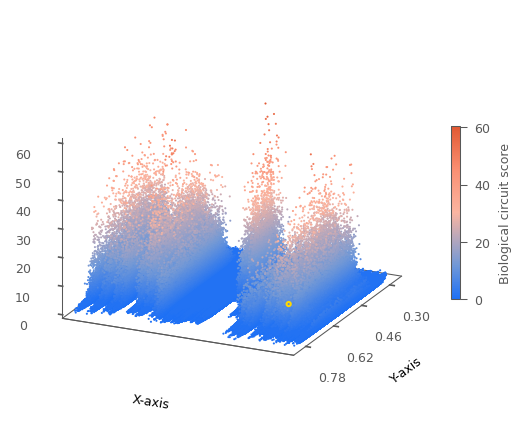

In [99]:


if plotting:
    #pt_to_in = lambda pt: pt / 72

    # === Style params you can tweak ===
    AXIS_HEX    = "#585858"   # any hex color (e.g., "#FF0055")
    AXIS_ALPHA  = 1        # 0=transparent, 1=opaque for axis lines & ticks
    LINEWIDTH   = 0.5         # axis, pane edge, and tick width

    # Convert once, reuse everywhere
    axis_rgba = mcolors.to_rgba(AXIS_HEX, AXIS_ALPHA)  # for axis lines & tick marks
    edge_rgba = mcolors.to_rgba(AXIS_HEX, 1.0)         # pane edge drawn fully opaque

    # Set plot parameters
    plt.rcParams.update({
        "font.size": 6, "axes.titlesize": 6, "axes.labelsize": 6,
        "legend.fontsize": 6, "xtick.labelsize": 6, "ytick.labelsize": 6,
        "pdf.fonttype": 42,           # embed TrueType so text stays editable in Illustrator
        "ps.fonttype": 42,            # same for EPS (if you ever export EPS)
        "pdf.use14corefonts": False,  # allow embedding non-core fonts
        "svg.fonttype": "none",      
    })

    # Create figure and 3D axes
    fig = plt.figure(figsize=(pt_to_in(270), pt_to_in(270)), dpi=150)
    ax = fig.add_subplot(111, projection="3d")

    # --- The Definitive Solution using zorder ---
    ax.grid(False)

    # Draw the floor pane edge on top
    ax.zaxis.pane.set_zorder(10)
    ax.zaxis.pane.set_alpha(1.0)
    ax.zaxis.pane.set_edgecolor(edge_rgba)
    ax.zaxis.pane.set_linewidth(LINEWIDTH)

    # Make side panes invisible
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')

    coldest   = "#1D70F6"   
    cold   = "#7399D6"   
    middle = "#FBB5A1"   
    warm   = "#FA8F72"   
    warmest   = "#E15832" 

    cw_mid = mcolors.LinearSegmentedColormap.from_list(
        "coolwarm_mid",
        [(0.00, coldest),
        (0.20, cold),
        (0.50, middle),
        (0.75, warm),
        (1.00, warmest)],
        N=256)                     

    cmap = cw_mid                       
    norm = mcolors.Normalize(vmin=circ_pred_sub.min(), vmax=circ_pred_sub.max())

    mask = circ_pred_sub >= 0
    x_pos   = idx_sub[mask]
    y_pos   = tox_pred_sub[mask]
    z_pos   = circ_pred_sub[mask]


    ax.scatter(
        x_pos, y_pos, z_pos, s=1,
        c=circ_pred_sub[mask], cmap=cw_mid, norm=norm,
        alpha=1, edgecolors="none", rasterized=True, label="Predicted"
    )


    ax.zaxis._axinfo["juggled"] = (1, 2, 0)

    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")


    # Axis line styles (x, y, z)
    for a in (ax.xaxis, ax.yaxis, ax.zaxis):
        a.line.set_color(axis_rgba)
        a.line.set_linewidth(LINEWIDTH)

    # Tick marks: same color & width on all three axes
    for axis in ('x', 'y', 'z'):
        ax.tick_params(axis=axis, which='both', width=LINEWIDTH, color=axis_rgba)

    # (Optional) If you also want tick LABELS to match the color:
    for axis in ('x', 'y', 'z'):
        ax.tick_params(axis=axis, which='both', width=LINEWIDTH, colors=axis_rgba)

    # Circuit score
    ax.zaxis._axinfo["tick"]["inward_factor"]  = 0.02
    ax.zaxis._axinfo["tick"]["outward_factor"] = 0.2

    # Permutations
    ax.xaxis._axinfo["tick"]["outward_factor"] = -0.2
    ax.xaxis.set_tick_params(direction="out")

    # Toxicity
    ax.yaxis._axinfo["tick"]["inward_factor"]  = -0.0
    ax.yaxis._axinfo["tick"]["outward_factor"] = -0.25
    ax.yaxis.set_tick_params(direction="out")

    # ---- Colorbar (scale bar) styled to match ----
    mappable = cm.ScalarMappable(norm=norm, cmap=cmap)  # assumes you have `cm` and `cmap` defined elsewhere
    cbar = fig.colorbar(
        mappable, ax=ax,
        fraction=0.03, pad=0.06, shrink=0.4, aspect=20
    )

    # Outline/border
    cbar.outline.set_edgecolor(axis_rgba)
    cbar.outline.set_linewidth(LINEWIDTH)

    # Tick marks & tick labels
    cbar.ax.tick_params(which='both', width=LINEWIDTH, color=axis_rgba, colors=axis_rgba)

    # Label (text) color
    cbar.set_label("Biological circuit score", fontsize=6, color=axis_rgba)

    def limits_with_pad(data, frac):
        data = np.asarray(data)
        lo = float(np.nanmin(data))
        hi = float(np.nanmax(data))
        span = hi - lo
        if span <= 0:
            # Constant data: pad relative to magnitude (or small absolute pad)
            base = max(abs(hi), 1.0)
            pad = base * frac
            return lo - pad, hi + pad
        pad = span * frac
        return lo - pad, hi + pad

    EDGE_PAD_FRAC_X = 0.0
    EDGE_PAD_FRAC_Y = 0.0  
    EDGE_PAD_FRAC_Z = 0.0  

    xlim = limits_with_pad(x_pos, EDGE_PAD_FRAC_X)
    ylim = limits_with_pad(y_pos, EDGE_PAD_FRAC_Y)
    zlim = limits_with_pad(z_pos, EDGE_PAD_FRAC_Z)

    zlim = (0, zlim[1]) 
    ax.set_xlim(*xlim); 
    ax.set_ylim(*ylim); 
    ax.set_zlim(*zlim)



    ###

    #to delete the permutation tick marks and text
    ax.set_xticks([])

    # === Exactly 4 Y major ticks with balanced edge gaps ===
    N_YTICKS = 4
    Y_BORDER_RATIO = 0.35  # 1.0 = border gap equals interior spacing; 0.0 = ticks on borders

    y0, y1 = ax.get_ylim()  # after autoscale
    d_y = (y1 - y0) / (N_YTICKS - 1 + 2*Y_BORDER_RATIO)  # interior spacing
    g_y = Y_BORDER_RATIO * d_y                            # border gap size
    y_ticks = y0 + g_y + d_y * np.arange(N_YTICKS)

    ax.yaxis.set_major_locator(FixedLocator(y_ticks))
    ax.yaxis.set_minor_locator(FixedLocator([]))  # ensure no extra minor ticks
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


    plt.rcParams['svg.fonttype'] = 'none'   # for SVG
    plt.rcParams['pdf.fonttype'] = 42       # for PDF (TrueType)

    #ax.view_init(elev=90, azim=0, roll = 90)
    ax.view_init(elev=20, azim=115, roll = 0)

    ax.set_proj_type("ortho")

    '''
    y_thresh = 0.75
    ax.plot(
        [xlim[0], xlim[1]],   # span full X range
        [y_thresh, y_thresh], # constant Y
        [zlim[0], zlim[0]],   # sit on the "floor" (z=0)
        color=axis_rgba, linewidth=1.0, alpha=1.0, zorder=20
    )
    '''

    # === Add a yellow border in screen space while keeping the original color ===
    perm_to_idx = {tuple(p): i for i, p in enumerate(valid_permutations)}
    perm_tgt = tuple(np.asarray(highest_score_details['permutation']).tolist())
    k = perm_to_idx.get(perm_tgt, None)

    if k is not None:
        x_k = float(k)
        y_k = float(tox_pred[k])
        z_k = float(circ_pred[k])

        # Draw a marker that has no face/edge but gets a stroke (halo) applied in screen space
        # Path effects are applied AFTER projection, so they don't get hidden by 3D depth sorting.
        hl, = ax.plot([x_k], [y_k], [z_k],
                    marker='o', markersize=2, linestyle='None',
                    markerfacecolor='none', markeredgewidth=0,
                    zorder=1e6)  # big zorder just in case

        hl.set_path_effects([
            pe.Stroke(linewidth=1, foreground='#FFD700'),  # yellow border thickness
            pe.Normal()
        ])

        # (Optional) nudge thickness for export sizes:
        # if fig.dpi > 150: hl.set_path_effects([pe.Stroke(linewidth=6, foreground='#FFD700'), pe.Normal()])

    else:
        print("Warning: target permutation not found in valid_permutations")


In [100]:
if plotting:
    fig.savefig(Path(output_dir) /f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/comp_to_function_with_optimal_{circuit_name}_{selected_graph}_{permutation_index}.pdf", dpi=300, bbox_inches="tight")

In [ ]:
if plotting:

    pt_to_in = lambda pt: pt / 72

    # === Style params you can tweak ===
    AXIS_HEX    = "#585858"   # any hex color (e.g., "#FF0055")
    AXIS_ALPHA  = 1        # 0=transparent, 1=opaque for axis lines & ticks
    LINEWIDTH   = 0.5         # axis, pane edge, and tick width

    # Convert once, reuse everywhere
    axis_rgba = mcolors.to_rgba(AXIS_HEX, AXIS_ALPHA)  # for axis lines & tick marks
    edge_rgba = mcolors.to_rgba(AXIS_HEX, 1.0)         # pane edge drawn fully opaque

    # Set plot parameters
    plt.rcParams.update({
        "font.size": 6, "axes.titlesize": 6, "axes.labelsize": 6,
        "legend.fontsize": 6, "xtick.labelsize": 6, "ytick.labelsize": 6,
    })

    # Create figure and 3D axes
    fig = plt.figure(figsize=(pt_to_in(270), pt_to_in(270)), dpi=150)
    ax = fig.add_subplot(111, projection="3d")

    # --- The Definitive Solution using zorder ---
    ax.grid(False)

    # Draw the floor pane edge on top
    ax.zaxis.pane.set_zorder(10)
    ax.zaxis.pane.set_alpha(1.0)
    ax.zaxis.pane.set_edgecolor(edge_rgba)
    ax.zaxis.pane.set_linewidth(LINEWIDTH)

    # Make side panes invisible
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')

    coldest   = "#1D70F6"   
    cold   = "#7399D6"   
    middle = "#FBB5A1"   
    warm   = "#FA8F72"   
    warmest   = "#E15832" 

    cw_mid = mcolors.LinearSegmentedColormap.from_list(
        "coolwarm_mid",
        [(0.00, coldest),
        (0.20, cold),
        (0.50, middle),
        (0.75, warm),
        (1.00, warmest)],
        N=256)                     

    cmap = cw_mid                       
    norm = mcolors.Normalize(vmin=circ_pred_sub.min(), vmax=circ_pred_sub.max())

    mask = circ_pred_sub >= 0
    x_pos   = idx_sub[mask]
    y_pos   = tox_pred_sub[mask]
    z_pos   = circ_pred_sub[mask]


    ax.scatter(
        x_pos, y_pos, z_pos, s=1,
        c=circ_pred_sub[mask], cmap=cw_mid, norm=norm,
        alpha=1, edgecolors="none", rasterized=True, label="Predicted"
    )


    ax.zaxis._axinfo["juggled"] = (1, 2, 0)

    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")


    # Axis line styles (x, y, z)
    for a in (ax.xaxis, ax.yaxis, ax.zaxis):
        a.line.set_color(axis_rgba)
        a.line.set_linewidth(LINEWIDTH)

    # Tick marks: same color & width on all three axes
    for axis in ('x', 'y', 'z'):
        ax.tick_params(axis=axis, which='both', width=LINEWIDTH, color=axis_rgba)

    # (Optional) If you also want tick LABELS to match the color:
    for axis in ('x', 'y', 'z'):
        ax.tick_params(axis=axis, which='both', width=LINEWIDTH, colors=axis_rgba)

    # Circuit score
    ax.zaxis._axinfo["tick"]["inward_factor"]  = 0.02
    ax.zaxis._axinfo["tick"]["outward_factor"] = 0.2

    # Permutations
    ax.xaxis._axinfo["tick"]["outward_factor"] = -0.2
    ax.xaxis.set_tick_params(direction="out")

    # Toxicity
    ax.yaxis._axinfo["tick"]["inward_factor"]  = -0.0
    ax.yaxis._axinfo["tick"]["outward_factor"] = -0.25
    ax.yaxis.set_tick_params(direction="out")

    # ---- Colorbar (scale bar) styled to match ----
    mappable = cm.ScalarMappable(norm=norm, cmap=cmap)  # assumes you have `cm` and `cmap` defined elsewhere
    cbar = fig.colorbar(
        mappable, ax=ax,
        fraction=0.03, pad=0.06, shrink=0.4, aspect=20
    )

    # Outline/border
    cbar.outline.set_edgecolor(axis_rgba)
    cbar.outline.set_linewidth(LINEWIDTH)

    # Tick marks & tick labels
    cbar.ax.tick_params(which='both', width=LINEWIDTH, color=axis_rgba, colors=axis_rgba)

    # Label (text) color
    cbar.set_label("Biological circuit score", fontsize=6, color=axis_rgba)

    def limits_with_pad(data, frac):
        data = np.asarray(data)
        lo = float(np.nanmin(data))
        hi = float(np.nanmax(data))
        span = hi - lo
        if span <= 0:
            # Constant data: pad relative to magnitude (or small absolute pad)
            base = max(abs(hi), 1.0)
            pad = base * frac
            return lo - pad, hi + pad
        pad = span * frac
        return lo - pad, hi + pad

    EDGE_PAD_FRAC_X = 0.0
    EDGE_PAD_FRAC_Y = 0.0  
    EDGE_PAD_FRAC_Z = 0.0  

    xlim = limits_with_pad(x_pos, EDGE_PAD_FRAC_X)
    ylim = limits_with_pad(y_pos, EDGE_PAD_FRAC_Y)
    zlim = limits_with_pad(z_pos, EDGE_PAD_FRAC_Z)

    zlim = (0, zlim[1]) 
    ax.set_xlim(*xlim); 
    ax.set_ylim(*ylim); 
    ax.set_zlim(*zlim)



    ###

    #to delete the permutation tick marks and text
    ax.set_xticks([])

    # === Exactly 4 Y major ticks with balanced edge gaps ===
    N_YTICKS = 4
    Y_BORDER_RATIO = 0.35  # 1.0 = border gap equals interior spacing; 0.0 = ticks on borders

    y0, y1 = ax.get_ylim()  # after autoscale
    d_y = (y1 - y0) / (N_YTICKS - 1 + 2*Y_BORDER_RATIO)  # interior spacing
    g_y = Y_BORDER_RATIO * d_y                            # border gap size
    y_ticks = y0 + g_y + d_y * np.arange(N_YTICKS)

    ax.yaxis.set_major_locator(FixedLocator(y_ticks))
    ax.yaxis.set_minor_locator(FixedLocator([]))  # ensure no extra minor ticks
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


    plt.rcParams['svg.fonttype'] = 'none'   # for SVG
    plt.rcParams['pdf.fonttype'] = 42       # for PDF (TrueType)

    ax.view_init(elev=90, azim=0, roll = 90)
    #ax.view_init(elev=20, azim=115, roll = 0)

    ax.set_proj_type("ortho")


    y_thresh = growth_score_threshold
    ax.plot(
        [xlim[0], xlim[1]],   # span full X range
        [y_thresh, y_thresh], # constant Y
        [zlim[0], zlim[0]],   # sit on the "floor" (z=0)
        color=axis_rgba, linewidth=1.0, alpha=1.0, zorder=20
    )






    # === Add a yellow border in screen space while keeping the original color ===
    perm_to_idx = {tuple(p): i for i, p in enumerate(valid_permutations)}
    perm_tgt = tuple(np.asarray(highest_score_details['permutation']).tolist())
    k = perm_to_idx.get(perm_tgt, None)

    if k is not None:
        x_k = float(k)
        y_k = float(tox_pred[k])
        z_k = float(circ_pred[k])

        # Draw a marker that has no face/edge but gets a stroke (halo) applied in screen space
        # Path effects are applied AFTER projection, so they don't get hidden by 3D depth sorting.
        hl, = ax.plot([x_k], [y_k], [z_k],
                    marker='o', markersize=2, linestyle='None',
                    markerfacecolor='none', markeredgewidth=0,
                    zorder=1e6)  # big zorder just in case

        hl.set_path_effects([
            pe.Stroke(linewidth=1, foreground='#FFD700'),  # yellow border thickness
            pe.Normal()
        ])

        # (Optional) nudge thickness for export sizes:
        # if fig.dpi > 150: hl.set_path_effects([pe.Stroke(linewidth=6, foreground='#FFD700'), pe.Normal()])

    else:
        print("Warning: target permutation not found in valid_permutations")


In [ ]:

if plotting:

    pt_to_in = lambda pt: pt / 72

    # === Style params you can tweak ===
    AXIS_HEX    = "#585858"   # any hex color (e.g., "#FF0055")
    AXIS_ALPHA  = 1        # 0=transparent, 1=opaque for axis lines & ticks
    LINEWIDTH   = 0.5         # axis, pane edge, and tick width

    # Convert once, reuse everywhere
    axis_rgba = mcolors.to_rgba(AXIS_HEX, AXIS_ALPHA)  # for axis lines & tick marks
    edge_rgba = mcolors.to_rgba(AXIS_HEX, 1.0)         # pane edge drawn fully opaque

    # Set plot parameters
    plt.rcParams.update({
        "font.size": 6, "axes.titlesize": 6, "axes.labelsize": 6,
        "legend.fontsize": 6, "xtick.labelsize": 6, "ytick.labelsize": 6,
    })

    # Create figure and 3D axes
    fig = plt.figure(figsize=(pt_to_in(270), pt_to_in(270)), dpi=150)
    ax = fig.add_subplot(111, projection="3d")

    # --- The Definitive Solution using zorder ---
    ax.grid(False)

    # Draw the floor pane edge on top
    ax.zaxis.pane.set_zorder(10)
    ax.zaxis.pane.set_alpha(1.0)
    ax.zaxis.pane.set_edgecolor(edge_rgba)
    ax.zaxis.pane.set_linewidth(LINEWIDTH)

    # Make side panes invisible
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')

    coldest   = "#1D70F6"   
    cold   = "#7399D6"   
    middle = "#FBB5A1"   
    warm   = "#FA8F72"   
    warmest   = "#E15832" 

    cw_mid = mcolors.LinearSegmentedColormap.from_list(
        "coolwarm_mid",
        [(0.00, coldest),
        (0.20, cold),
        (0.50, middle),
        (0.75, warm),
        (1.00, warmest)],
        N=256)                     

    cmap = cw_mid                       
    norm = mcolors.Normalize(vmin=circ_pred_sub.min(), vmax=circ_pred_sub.max())

    mask = circ_pred_sub >= 0
    x_pos   = idx_sub[mask]
    y_pos   = tox_pred_sub[mask]
    z_pos   = circ_pred_sub[mask]


    ax.scatter(
        x_pos, y_pos, z_pos, s=1,
        c=circ_pred_sub[mask], cmap=cw_mid, norm=norm,
        alpha=1, edgecolors="none", rasterized=True, label="Predicted"
    )


    ax.zaxis._axinfo["juggled"] = (1, 2, 0)

    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")


    # Axis line styles (x, y, z)
    for a in (ax.xaxis, ax.yaxis, ax.zaxis):
        a.line.set_color(axis_rgba)
        a.line.set_linewidth(LINEWIDTH)

    # Tick marks: same color & width on all three axes
    for axis in ('x', 'y', 'z'):
        ax.tick_params(axis=axis, which='both', width=LINEWIDTH, color=axis_rgba)

    # (Optional) If you also want tick LABELS to match the color:
    for axis in ('x', 'y', 'z'):
        ax.tick_params(axis=axis, which='both', width=LINEWIDTH, colors=axis_rgba)

    # Circuit score
    ax.zaxis._axinfo["tick"]["inward_factor"]  = 0.02
    ax.zaxis._axinfo["tick"]["outward_factor"] = 0.2

    # Permutations
    ax.xaxis._axinfo["tick"]["outward_factor"] = -0.2
    ax.xaxis.set_tick_params(direction="out")

    # Toxicity
    ax.yaxis._axinfo["tick"]["inward_factor"]  = -0.0
    ax.yaxis._axinfo["tick"]["outward_factor"] = -0.25
    ax.yaxis.set_tick_params(direction="out")

    # ---- Colorbar (scale bar) styled to match ----
    mappable = cm.ScalarMappable(norm=norm, cmap=cmap)  # assumes you have `cm` and `cmap` defined elsewhere
    cbar = fig.colorbar(
        mappable, ax=ax,
        fraction=0.03, pad=0.06, shrink=0.4, aspect=20
    )

    # Outline/border
    cbar.outline.set_edgecolor(axis_rgba)
    cbar.outline.set_linewidth(LINEWIDTH)

    # Tick marks & tick labels
    cbar.ax.tick_params(which='both', width=LINEWIDTH, color=axis_rgba, colors=axis_rgba)

    # Label (text) color
    cbar.set_label("Biological circuit score", fontsize=6, color=axis_rgba)

    def limits_with_pad(data, frac):
        data = np.asarray(data)
        lo = float(np.nanmin(data))
        hi = float(np.nanmax(data))
        span = hi - lo
        if span <= 0:
            # Constant data: pad relative to magnitude (or small absolute pad)
            base = max(abs(hi), 1.0)
            pad = base * frac
            return lo - pad, hi + pad
        pad = span * frac
        return lo - pad, hi + pad

    EDGE_PAD_FRAC_X = 0.0
    EDGE_PAD_FRAC_Y = 0.0  
    EDGE_PAD_FRAC_Z = 0.0  

    xlim = limits_with_pad(x_pos, EDGE_PAD_FRAC_X)
    ylim = limits_with_pad(y_pos, EDGE_PAD_FRAC_Y)
    zlim = limits_with_pad(z_pos, EDGE_PAD_FRAC_Z)

    zlim = (0, zlim[1]) 
    ax.set_xlim(*xlim); 
    ax.set_ylim(*ylim); 
    ax.set_zlim(*zlim)



    ###

    #to delete the permutation tick marks and text
    ax.set_xticks([])

    # === Exactly 4 Y major ticks with balanced edge gaps ===
    N_YTICKS = 4
    Y_BORDER_RATIO = 0.35  # 1.0 = border gap equals interior spacing; 0.0 = ticks on borders

    y0, y1 = ax.get_ylim()  # after autoscale
    d_y = (y1 - y0) / (N_YTICKS - 1 + 2*Y_BORDER_RATIO)  # interior spacing
    g_y = Y_BORDER_RATIO * d_y                            # border gap size
    y_ticks = y0 + g_y + d_y * np.arange(N_YTICKS)

    ax.yaxis.set_major_locator(FixedLocator(y_ticks))
    ax.yaxis.set_minor_locator(FixedLocator([]))  # ensure no extra minor ticks
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


    plt.rcParams['svg.fonttype'] = 'none'   # for SVG
    plt.rcParams['pdf.fonttype'] = 42       # for PDF (TrueType)

    ax.view_init(elev=0, azim=90, roll = 0)
    #ax.view_init(elev=20, azim=115, roll = 0)

    ax.set_proj_type("ortho")


    y_thresh = growth_score_threshold
    ax.plot(
        [xlim[0], xlim[1]],   # span full X range
        [y_thresh, y_thresh], # constant Y
        [zlim[0], zlim[0]],   # sit on the "floor" (z=0)
        color=axis_rgba, linewidth=1.0, alpha=1.0, zorder=20
    )




    # === Add a yellow border in screen space while keeping the original color ===
    perm_to_idx = {tuple(p): i for i, p in enumerate(valid_permutations)}
    perm_tgt = tuple(np.asarray(highest_score_details['permutation']).tolist())
    k = perm_to_idx.get(perm_tgt, None)

    if k is not None:
        x_k = float(k)
        y_k = float(tox_pred[k])
        z_k = float(circ_pred[k])

        # Draw a marker that has no face/edge but gets a stroke (halo) applied in screen space
        # Path effects are applied AFTER projection, so they don't get hidden by 3D depth sorting.
        hl, = ax.plot([x_k], [y_k], [z_k],
                    marker='o', markersize=2, linestyle='None',
                    markerfacecolor='none', markeredgewidth=0,
                    zorder=1e6)  # big zorder just in case

        hl.set_path_effects([
            pe.Stroke(linewidth=1, foreground='#FFD700'),  # yellow border thickness
            pe.Normal()
        ])

        # (Optional) nudge thickness for export sizes:
        # if fig.dpi > 150: hl.set_path_effects([pe.Stroke(linewidth=6, foreground='#FFD700'), pe.Normal()])

    else:
        print("Warning: target permutation not found in valid_permutations")



In [ ]:
if plotting:

    # ===== Style =====
    pt_to_in = lambda pt: pt / 72
    AXIS_HEX    = "#585858"
    AXIS_ALPHA  = 1.0
    LINEWIDTH   = 0.5
    axis_rgba = mcolors.to_rgba(AXIS_HEX, AXIS_ALPHA)

    plt.rcParams.update({
        "font.size": 6, "axes.titlesize": 6, "axes.labelsize": 6,
        "legend.fontsize": 6, "xtick.labelsize": 6, "ytick.labelsize": 6,
        'svg.fonttype': 'none',   # crisp SVG text
        'pdf.fonttype': 42,       # TrueType in PDF
    })

    # ===== Colormap (same as your 3D) =====
    coldest = "#1D70F6"; cold = "#7399D6"; middle = "#FBB5A1"; warm = "#FA8F72"; warmest = "#E15832"
    cw_mid = mcolors.LinearSegmentedColormap.from_list(
        "coolwarm_mid",
        [(0.00, coldest), (0.20, cold), (0.50, middle), (0.75, warm), (1.00, warmest)],
        N=256
    )

    # ===== Data prep =====
    mask = circ_pred_sub >= 0
    x = tox_pred_sub[mask]      # toxicity on X
    y = circ_pred_sub[mask]     # circuit score on Y
    norm = mcolors.Normalize(vmin=y.min(), vmax=y.max())

    def limits_with_pad(data, frac):
        data = np.asarray(data)
        lo = float(np.nanmin(data)); hi = float(np.nanmax(data))
        span = hi - lo
        if span <= 0:
            base = max(abs(hi), 1.0)
            pad = base * frac
            return lo - pad, hi + pad
        pad = span * frac
        return lo - pad, hi + pad

    EDGE_PAD_FRAC_X = 0.0
    EDGE_PAD_FRAC_Y = 0.0
    xlim = limits_with_pad(x, EDGE_PAD_FRAC_X)
    ylim = limits_with_pad(y, EDGE_PAD_FRAC_Y)
    ylim = (0, ylim[1])  # floor at 0 to match your 3D z-floor

    # ===== Figure =====
    fig, ax = plt.subplots(figsize=(pt_to_in(270), pt_to_in(270)), dpi=150)

    # Main scatter: color by circuit score (redundant but matches your legend)
    sc = ax.scatter(
        x, y, s=3, c=y, cmap=cw_mid, norm=norm,
        alpha=1.0, edgecolors="none", rasterized=True, label="Predicted"
    )

    # Axes, ticks, colors
    for spine in ax.spines.values():
        spine.set_linewidth(LINEWIDTH)
        spine.set_edgecolor(axis_rgba)

    ax.tick_params(axis='both', which='both', width=LINEWIDTH, colors=axis_rgba)
    ax.set_xlabel("Toxicity")
    ax.set_ylabel("Biological circuit score")
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

    # Optional: exactly 4 X major ticks with balanced edge gaps (to mimic your Y trick on 3D)
    N_XTICKS = 4
    X_BORDER_RATIO = 0.35
    x0, x1 = ax.get_xlim()
    d_x = (x1 - x0) / (N_XTICKS - 1 + 2*X_BORDER_RATIO)
    g_x = X_BORDER_RATIO * d_x
    x_ticks = x0 + g_x + d_x * np.arange(N_XTICKS)
    ax.xaxis.set_major_locator(FixedLocator(x_ticks))
    ax.xaxis.set_minor_locator(FixedLocator([]))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Y ticks: you can enforce 4 if you like (comment out if you prefer auto)
    N_YTICKS = 4
    Y_BORDER_RATIO = 0.35
    y0, y1 = ax.get_ylim()
    d_y = (y1 - y0) / (N_YTICKS - 1 + 2*Y_BORDER_RATIO)
    g_y = Y_BORDER_RATIO * d_y
    y_ticks = y0 + g_y + d_y * np.arange(N_YTICKS)
    ax.yaxis.set_major_locator(FixedLocator(y_ticks))
    ax.yaxis.set_minor_locator(FixedLocator([]))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Horizontal threshold line at toxicity = y_thresh? (In 2D we use x = tox, y = circ)
    # In the 3D plot this line was at Y=0.75 on the floor (toxicity). Here we draw a vertical line at x = 0.75.
    y_thresh = growth_score_threshold
    ax.axvline(y_thresh, color=axis_rgba, linewidth=1.0)

    # Colorbar
    cbar = fig.colorbar(sc, ax=ax, fraction=0.03, pad=0.06, shrink=0.9, aspect=20)
    cbar.outline.set_edgecolor(axis_rgba)
    cbar.outline.set_linewidth(LINEWIDTH)
    cbar.ax.tick_params(which='both', width=LINEWIDTH, color=axis_rgba, colors=axis_rgba)
    cbar.set_label("Biological circuit score", fontsize=6, color=axis_rgba)

    # ===== Highlight target permutation with a yellow halo =====
    perm_to_idx = {tuple(p): i for i, p in enumerate(valid_permutations)}
    perm_tgt = tuple(np.asarray(highest_score_details['permutation']).tolist())
    k = perm_to_idx.get(perm_tgt, None)

    if k is not None:
        x_k = float(tox_pred[k])
        y_k = float(circ_pred[k])

        # Yellow “glow” marker
        hl = ax.plot([x_k], [y_k], marker='o', markersize=3, linestyle='None',
                    markerfacecolor='none', markeredgewidth=0, zorder=1e6)[0]
        hl.set_path_effects([pe.Stroke(linewidth=2, foreground='#FFD700'), pe.Normal()])

        # Annotate exact values so you can confirm 37 vs 42, etc.
        ax.annotate(f"tox={x_k:.3f}\nscore={y_k:.3f}",
                    xy=(x_k, y_k), xytext=(5, 5), textcoords='offset points',
                    fontsize=6, color=AXIS_HEX,
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec=AXIS_HEX, lw=0.3))
    else:
        print("Warning: target permutation not found in valid_permutations")

    plt.tight_layout()
    plt.show()


In [ ]:
t_total_end = time.perf_counter()
    
total_time = t_total_end - t_total_start

print(total_time)

In [ ]:
# build paths you specified
base = Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}"
metadata_path = base / f"run_time_{circuit_name}_{selected_graph}_{permutation_index}.json"

# make sure directory exists
metadata_path.parent.mkdir(parents=True, exist_ok=True)

# record to save
record = {
    "circuit_name": circuit_name,
    "selected_graph": selected_graph,
    "permutation_index": permutation_index,
    "total_time_seconds": total_time
}

# write (overwrite each run)
with metadata_path.open("w") as f:
    json.dump(record, f, indent=2)

print(f"Saved run time metadata to: {metadata_path}")

In [ ]:
stop 

## Previous code

In [ ]:
# Find top N circuit scores
N = 20  # Change this number to get more or fewer top scores
top_n_indices = np.argsort(circuit_scores_high_performing_no_roadblocking_toxicity_filtered)[-N:][::-1]  # Get indices of top N scores in descending order

print(f"\nTop {N} Circuit Scores (no roadblocking, toxicity > 0.75):")
print("Rank | Circuit Score | Toxicity Score | Roadblocking | Permutation")
print("-" * 100)

# Store highest score details for later
highest_score_details = {}

for rank, idx in enumerate(top_n_indices, 1):
    # Get the corresponding index in the original filtered arrays
    corresponding_index = idx

    # Get permutation
    best_permutation = permutations_high_performing_no_roadblocking_toxicity_filtered[corresponding_index]

    # Get roadblocking flag for this design
    roadblock_flag = roadblocking_flags_high_performing_no_roadblocking_toxicity_filtered[corresponding_index]

    # Print formatted output
    print(f"{rank:4d} | {circuit_scores_high_performing_no_roadblocking_toxicity_filtered[idx]:12.4f} | "
          f"{toxicity_scores_high_performing_no_roadblocking_toxicity_filtered[idx]:13.4f} | "
          f"{str(roadblock_flag):11} | {best_permutation}")

    # Store details for rank 1
    if rank == 1:
        highest_score_details = {
            'circuit_score': circuit_scores_high_performing_no_roadblocking_toxicity_filtered[idx],
            'toxicity_score': toxicity_scores_high_performing_no_roadblocking_toxicity_filtered[idx],
            'roadblocking': roadblock_flag,
            #'predicted_circuit': y_pred_circuit_filtered[corresponding_index],
            #'predicted_toxicity': y_pred_toxicity_filtered[corresponding_index],
            'permutation': best_permutation
        }

# Print detailed information for highest scoring design after the table
print("\n" + "="*50)
print("Detailed information for highest scoring design:")
print("="*50)
print(f"Highest actual circuit score: {highest_score_details['circuit_score']}")
print(f"Corresponding actual toxicity score: {highest_score_details['toxicity_score']}")
print(f"Roadblocking: {highest_score_details['roadblocking']}")
#print(f"Predicted circuit score: {highest_score_details['predicted_circuit']}")
#print(f"Predicted toxicity score: {highest_score_details['predicted_toxicity']}")
print(f"Permutation: {highest_score_details['permutation']}")

In [ ]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
fig.tight_layout(pad=4.0)  # Add space between subplots

# Data preparation
ranks = list(range(1, N + 1))
circuit_scores = circuit_scores_high_performing_no_roadblocking_toxicity_filtered[top_n_indices]
toxicity_scores = toxicity_scores_high_performing_no_roadblocking_toxicity_filtered[top_n_indices]

# Plot 1: Circuit Scores
bars1 = ax1.bar(ranks, circuit_scores, color='royalblue', alpha=0.7)
ax1.set_title('Top Circuit Scores by Rank', fontsize=12, pad=15)
ax1.set_xlabel('Rank')
ax1.set_ylabel('Circuit Score')
ax1.grid(True, linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom', rotation=0)

# Plot 2: Toxicity Scores
bars2 = ax2.bar(ranks, toxicity_scores, color='mediumseagreen', alpha=0.7)
ax2.set_title('Corresponding Toxicity Scores', fontsize=12, pad=15)
ax2.set_xlabel('Rank')
ax2.set_ylabel('Toxicity Score')
ax2.grid(True, linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom', rotation=0)

# Adjust layout
plt.tight_layout()

# Add a title for the entire figure
fig.suptitle('Analysis of Top Performing Circuits', fontsize=14, y=1.02)

# Save figure if needed
# plt.savefig('top_circuits_analysis.png', dpi=300, bbox_inches='tight')

plt.show()

# Optional: Print some statistics
print("\nStatistics Summary:")
print("-" * 50)
print(f"Circuit Scores - Mean: {np.mean(circuit_scores):.3f}, Std: {np.std(circuit_scores):.3f}")
print(f"Toxicity Scores - Mean: {np.mean(toxicity_scores):.3f}, Std: {np.std(toxicity_scores):.3f}")

#### Draw the top design

In [ ]:
G = assign_representations_with_io_nodes_3(adj_matrix, postech_v1_hill_function_parameters, highest_score_details['permutation'])
draw_network_with_colors_and_labels_from_G(G)

In [ ]:
plot_circuit_layered(G, show_in_notebook=True, notebook_width = 600, save = False)
plot_circuit_with_parts_layered(G, show_in_notebook=True, notebook_width = 600, save = False)

In [ ]:
plot_circuit_layered(G, show_in_notebook=True, notebook_width = 500, save = False)

## Simulated annealing

Cello 2 parameters

In [ ]:
saved_run_results = []
run_number = []
num_runs = 3
top_circuit_score = 0
top_toxicity_score = 0
top_solution = 0

for run in range(0, num_runs):
    initial_solution = random_part_selection(postech_v1_hill_function_parameters, gate_count)
    MAXTEMP = 100.0
    MINTEMP = 0.001
    steps = 600
    T0_steps = 100

    optimized_score, optimal_toxicty, optimal_solution = simulated_annealing_cello2(
        adj_matrix, initial_solution, MAXTEMP, MINTEMP, steps, T0_steps,
        input_signals_list_small_molecules, input_signals_list_binary,
        postech_v1_hill_function_parameters, gate_toxicity_df, D_GROWTH_THRESHOLD=growth_score_threshold)

    saved_run_results.append(optimized_score)
    run_number.append(run)
    
    if optimized_score > top_circuit_score:
        top_circuit_score = optimized_score
        top_toxicity_score = optimal_toxicty
        top_solution = optimal_solution

# Plotting iterations vs highest score
plt.figure(figsize=(8, 4))
plt.scatter(run_number, saved_run_results, color='b')
plt.title('Iterations vs Highest Score')
plt.xlabel('Iteration')
plt.ylabel('Circuit Score')
plt.show()

Cello 2 parameters and more, including random seed

In [ ]:
total = round(len(valid_permutations)*percentage)  

In [ ]:
import os, json, math, random, itertools
import numpy as np
import pandas as pd
from datetime import datetime

MINTEMP = 1e-3  
MAXTEMPS = [1, 1e1, 1e2, 1e3]  
steps = round(total*(1-0.02))
T0_steps = round(total*(0.02))
N_SEEDS = 3
N_INITIALS = 1

results_csv = "sa_sweep_results.csv"
solutions_json = "sa_sweep_solutions.json"   # to store full optimal solutions

# ----------------------------------------------------
# Draw 3 random seeds (independent of initial states)
# ----------------------------------------------------
seeds = [int.from_bytes(os.urandom(4), "little") for _ in range(N_SEEDS)]

# ----------------------------------------------------
# Precompute 3 random initial solutions ONCE so that
# all seeds test the SAME 3 initial states.
# Use a dedicated RNG state to avoid coupling with `seeds`.
# ----------------------------------------------------
tmp_seed_for_initials = int.from_bytes(os.urandom(4), "little")
random.seed(tmp_seed_for_initials)
np.random.seed(tmp_seed_for_initials)

initial_solutions = []
for i in range(N_INITIALS):
    init_sol = random_part_selection(postech_v1_hill_function_parameters, gate_count)
    initial_solutions.append(init_sol)

# -------------------------------------------------------
# Run sweep: for each seed × initial_solution × MAXTEMP
# -------------------------------------------------------
rows = []
solutions_store = []  # list of dicts (seed, init_id, maxtemp, solution list)

top_circuit_score = -float("inf")
top_toxicity_score = None
top_solution = None
top_meta = None

run_counter = 0

for seed in seeds:
    # set PRNGs for this run (affects SA stochasticity, not the initial_solutions)
    random.seed(seed)
    np.random.seed(seed)

    for init_id, initial_solution in enumerate(initial_solutions):
        for maxt in MAXTEMPS:
            run_counter += 1

            optimized_score, optimal_toxicty, optimal_solution = simulated_annealing_cello2(
                adj_matrix,
                initial_solution,
                maxt, MINTEMP,
                steps, T0_steps,
                input_signals_list_small_molecules,
                input_signals_list_binary,
                postech_v1_hill_function_parameters,
                gate_toxicity_df,
                D_GROWTH_THRESHOLD=growth_score_threshold,
                plot=False  # keep off for batch
            )

            # Save a compact row for CSV
            rows.append({
                "run_id": run_counter,
                "seed": seed,
                "initial_id": init_id,         # 0..2
                "MAXTEMP": maxt,
                "MINTEMP": MINTEMP,
                "steps": steps,
                "T0_steps": T0_steps,
                "optimized_score": optimized_score,
                "optimal_toxicity": optimal_toxicty,
            })

            # Save the full optimal solution separately (JSON)
            solutions_store.append({
                "run_id": run_counter,
                "seed": seed,
                "initial_id": init_id,
                "MAXTEMP": maxt,
                "MINTEMP": MINTEMP,
                "optimal_solution": optimal_solution,  # list-like
            })

            # Track global best
            if optimized_score > top_circuit_score:
                top_circuit_score = optimized_score
                top_toxicity_score = optimal_toxicty
                top_solution = optimal_solution
                top_meta = {
                    "seed": seed,
                    "initial_id": init_id,
                    "MAXTEMP": maxt,
                    "MINTEMP": MINTEMP,
                }

# --------------------------------
# Save results
# --------------------------------
df = pd.DataFrame(rows)
df["timestamp"] = datetime.now().isoformat(timespec="seconds")
df.to_csv(results_csv, index=False)

with open(solutions_json, "w") as f:
    json.dump({
        "timestamp": datetime.now().isoformat(timespec="seconds"),
        "solutions": solutions_store,
        "best_overall": {
            "optimized_score": top_circuit_score,
            "optimal_toxicity": top_toxicity_score,
            "meta": top_meta,
            "optimal_solution": top_solution,
        }
    }, f, indent=2)

print(f"Saved run table to: {results_csv}")
print(f"Saved solutions to: {solutions_json}")
print("Best overall:")
print("  score:", top_circuit_score)
print("  tox:", top_toxicity_score)
print("  meta:", top_meta)


In [ ]:
G = assign_representations_with_io_nodes_3(adj_matrix, postech_v1_hill_function_parameters, top_solution) 
print("Synthetic gene circuit")
draw_network_with_colors_and_labels_from_G(G)

expected_logic_current = simulate_signal_propagation_binary(G, input_signals_list_binary)
actual_logic_current = simulate_signal_propagation(G, input_signals_list_small_molecules)
circuit_score_current = calculate_circuit_score(expected_logic_current, actual_logic_current)
toxicity_score_current, detailed_results = calculate_toxicity_score(input_signals_list_small_molecules, G, gate_toxicity_df)
print(circuit_score_current)
print(toxicity_score_current)